In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)



In [2]:
df_train = pd.read_csv("../data/raw/train.csv",index_col=0)
df_test = pd.read_csv("../data/raw/test.csv", index_col=0)
df_test["SalePrice"] = 0

df = pd.concat([df_train, df_test], sort=False)
df = df.drop("SalePrice", axis=1)

xx = df.duplicated()
xx[xx]

Id
2714    True
2866    True
dtype: bool

In [3]:
def load_test_train_data() :

    print("\n\n*****\nLoading test and train data....")
    df_train = pd.read_csv("../data/raw/train.csv",index_col=0)
    df_test = pd.read_csv("../data/raw/test.csv", index_col=0)
    df_train["data_type"] = "train"
    df_test["data_type"] = "test"
    df_test["SalePrice"] = 0

    df = pd.concat([df_train, df_test], sort=False)
    df = df.reset_index(drop=True)

    print("Train Data Shape :", df_train.shape)
    print("Test Data Shape : ", df_test.shape)
    print("Combined Data Shape : ", df.shape)

    return (df_train, df_test, df)


In [4]:
def write_processed_files(df):
    
    print("\n\n*****\nGenerating processed data files...")

    train = df[df.data_type_train == 1].reset_index(drop=True)
    test = df[df.data_type_test == 1].reset_index(drop=True)    

    train.drop("data_type_train", axis=1, inplace=True)
    train.drop("data_type_test", axis=1, inplace=True)    
    test.drop("data_type_train", axis=1,inplace=True)
    test.drop("data_type_test", axis=1,inplace=True)
    test.drop("SalePrice", axis=1,inplace=True)
    
    df.to_csv("../data/processed_data/full_processed.csv")
    train.to_csv("../data/processed_data/train_processed.csv",index=False)
    test.to_csv("../data/processed_data/test_processed.csv", index=False)

    return None



In [5]:
def get_column_names_by_type(df):
    numeric_columns = df.describe().columns
    non_numeric_columns = [i for i in df.columns if i not in numeric_columns]
    return (numeric_columns, non_numeric_columns)
    

In [6]:
#missing value counter
def na_counter(data):
    coln = list(data.columns)

    if data.isnull().any().sum() == 0:
        return pd.DataFrame(columns=['NA Count',"PERCENT"])
    
    na_dict ={}
    for col in coln:
        if data[col].isnull().any()==True:
            na_count = data[col].isnull().sum()
            na_percent = data[col].isnull().sum()/len(data)
            na_dict[col]=[na_count, na_percent]
    df_na =pd.DataFrame(na_dict).T
    df_na.columns = ['NA Count',"PERCENT"]
    df_na.index.name = "Column"
    return df_na

In [7]:
def impute_null_fields(df):
    
    print("\n\n*****\nImputing Null values....")
    print("Null counts before imputing:")
    print(na_counter(df))
    

    """ ?? """
    df["MSZoning"] = df["MSZoning"].fillna("RM")
    df["LotFrontage"] = df["LotFrontage"].fillna(df.groupby("Neighborhood")["LotFrontage"].transform("mean"))
    df["MasVnrType"] = df["MasVnrType"].fillna("None") 
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0.0) 
    df["BsmtQual"] = df["BsmtQual"].fillna("NoBsmt")
    df["BsmtCond"] = df["BsmtCond"].fillna("NoBsmt")
    df["BsmtExposure"] = df["BsmtExposure"].fillna("NoBsmt")
    df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NoBsmt")
    df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NoBsmt")
    df['Exterior1st'] = df['Exterior1st'].fillna("None") 
    df['Exterior2nd'] = df['Exterior2nd'].fillna("None")
    df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0) 
    df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0) 
    df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0) 
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0) 
    

    """ Only one row missing the value, impute with "SBrkr" which is the most used """
    df.Electrical = df.Electrical.fillna("SBrkr")

    """ Impute with equavelant of overall house quality : Average, equivalent "TA" """
    df.KitchenQual = df.KitchenQual.fillna("None")

    df.FireplaceQu = df.FireplaceQu.fillna("None")
    
    """ First change Garage Type for row with Null area and then change Garage Area """
    df.loc[df.GarageArea.isnull(), "GarageType"] = np.nan
    df.loc[df.GarageArea.isnull(), "GarageArea"] = 0
    
        

    """ For one record with Garage Area 360 and with missing Garage values, set to average values based on Overall Quality """
    df.loc[(df.GarageArea==360) & df.GarageFinish.isnull(), "GarageFinish"] = "Unf"
    df.loc[(df.GarageArea==360) & df.GarageQual.isnull(), "GarageQual"] = "TA"
    df.loc[(df.GarageArea==360) & df.GarageCond.isnull(), "GarageCond"] = "TA"
    """ Setting the Garage built to "Year Remodelled" """
    df.loc[(df.GarageArea==360) & df.GarageYrBlt.isnull(), "GarageYrBlt"] = df.YearRemodAdd


    
    """ Set rest of the missing Garage valies to None and GarageCars to zero"""
    df.GarageFinish = df.GarageFinish.fillna("None")
    df.GarageQual = df.GarageQual.fillna("None")
    df.GarageCond = df.GarageCond.fillna("None")
    df.GarageType = df.GarageType.fillna("None")

    df.GarageCars = df.GarageCars.fillna(0)


    """ Is it correct to fill with Zero for Year built as the scale will change compared to most values in 1900""" 
    df.GarageYrBlt = df.GarageYrBlt.fillna(0)


    """ Impiute with Typ as mentioned in documentation. There does not seem to be clear relation with
        Overall quality fields
    """
    df.loc[df.Functional.isnull(), "Functional"] = "Typ"


    """Basement Fullbath and Halfbath NA values are related to  houses without basements. Soe set them to 0 """
    df.BsmtFullBath = df.BsmtFullBath.fillna(0)
    df.BsmtHalfBath = df.BsmtHalfBath.fillna(0)
    
    
    """ ?? """
    df['SaleType'] = df['SaleType'].fillna("Oth")
    df['GarageQual'] = df['GarageQual'].fillna("None")

    print("\n\n\nNull counts after imputing:")
    print(na_counter(df))

    return df

In [8]:
def correct_data(df):
    
    print("\n\n*****\nCorrecting incorrect data values...")

    """Seems the year is 2207 is a typo, setting to the year remodeled"""
    df.loc[df.GarageYrBlt==2207, "GarageYrBlt"] = 2007
    return df

In [9]:

def transform_ordinal(df):
    typical_graded_cols = ["HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "ExterQual",
                          "ExterCond", "BsmtQual", "BsmtCond"]
    typical_grade_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

    for i in typical_graded_cols:
        df[i].replace(typical_grade_map, inplace=True)
    
    df['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)
    df['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)
    
    return df

In [10]:
def drop_columns(df):
    
    print("\n\n*****\nDropping selective columns...")
    columsn_to_drop = ["Street", "Alley","Utilities","Condition2", "RoofMatl", "LowQualFinSF","GarageYrBlt",
                       "GarageQual", "PoolQC","Fence","MiscFeature", "GarageCond","MiscVal"]

    columsn_to_drop = columsn_to_drop + ["MoSold", "YrSold"]
    
    print("\n\n*****\nNo of columns before dropping : ", len(df.columns))
    print("No of columns to drop : ", len(columsn_to_drop))
    
    df.drop(columsn_to_drop, axis=1, inplace=True)
    print("No of columns after dropping : ", len(df.columns))

    return df

In [11]:
def value_counts(data, kind="non-numeric", threshold = 15): 
    
    continuous_col = data.describe().columns
    categorical_col =data.drop(continuous_col, axis=1).columns
    
    if (kind=="non-numeric"):
        columns = categorical_col
    elif (kind == "numeric"):
        columns = continuous_col
    else :
        columns = data.columns
    
    for col in (columns):
        if (len(data[col].value_counts())<= threshold):
            print(data[col].value_counts())
            print("")

In [12]:
def print_data_stats(df):
    print("\n\n*****\nPrinting stats...")
    print("No of rows : ", df.shape[0])
    print("No of columns : ", df.shape[1])
    
    x,y = get_column_names_by_type(df)
    print("Numeric columns : ", len(x))
    print("Non Numeric columns : ", len(y))
    
    print("\n\nNull counts :")
    print(na_counter(df))
    
    return df

In [13]:
def change_column_type(df):
    
    print("\n\n*****\n Changing some columns to category ...")
    df.MSSubClass = df.MSSubClass.astype("category")    
    return df

In [14]:
def standardize_features(df):

    print("\n\n*****\n Standardizing numeric columns ...")
    sclr = StandardScaler()
    num_cols, cat_cols = get_column_names_by_type(df)
    num_cols = num_cols.drop("SalePrice")
    
    
    df2 = sclr.fit_transform(df[num_cols])
    df.loc[:,num_cols] = df2

    return df

In [15]:
def process_raw_data(standardize = True, use_ordinal=False):
    
    print("\n\n*****\n Processing raw files to generate processed files... hold tight...")
    train_df, test_df, full_df = load_test_train_data()
    
    final_df = full_df.copy().\
        pipe(print_data_stats).\
        pipe(impute_null_fields).\
        pipe(correct_data)
#     .\
#         pipe(change_column_type)
# #     .\
#         pipe(drop_columns)
    
    if (use_ordinal):
        final_df = transform_ordinal(final_df)

#     if (standardize):
#         final_df = standardize_features(final_df)
        
#     final_df = final_df.pipe(pd.get_dummies).\
#             pipe(print_data_stats).\
#             pipe(write_processed_files)

    return(train_df, test_df, full_df,final_df)
    

In [16]:
train,test,all_df,fin_df = process_raw_data()



*****
 Processing raw files to generate processed files... hold tight...


*****
Loading test and train data....
Train Data Shape : (1460, 81)
Test Data Shape :  (1459, 81)
Combined Data Shape :  (2919, 81)


*****
Printing stats...
No of rows :  2919
No of columns :  81
Numeric columns :  37
Non Numeric columns :  44


Null counts :
              NA Count   PERCENT
Column                          
MSZoning           4.0  0.001370
LotFrontage      486.0  0.166495
Alley           2721.0  0.932169
Utilities          2.0  0.000685
Exterior1st        1.0  0.000343
Exterior2nd        1.0  0.000343
MasVnrType        24.0  0.008222
MasVnrArea        23.0  0.007879
BsmtQual          81.0  0.027749
BsmtCond          82.0  0.028092
BsmtExposure      82.0  0.028092
BsmtFinType1      79.0  0.027064
BsmtFinSF1         1.0  0.000343
BsmtFinType2      80.0  0.027407
BsmtFinSF2         1.0  0.000343
BsmtUnfSF          1.0  0.000343
TotalBsmtSF        1.0  0.000343
Electrical         1.0  0.000343
Bs

In [17]:
num_cols,cat_cols =  get_column_names_by_type(all_df)

In [18]:
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()

    

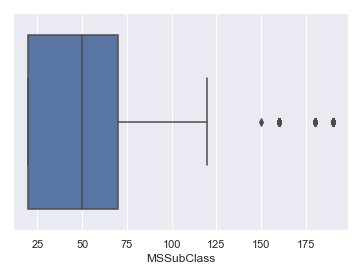

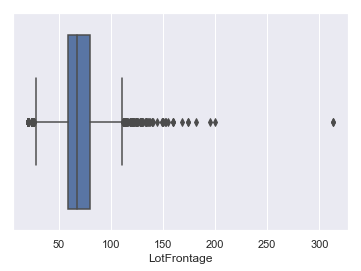

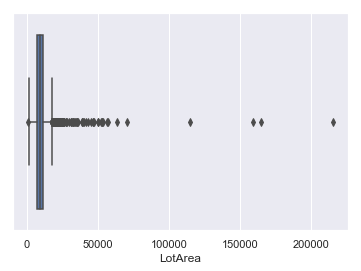

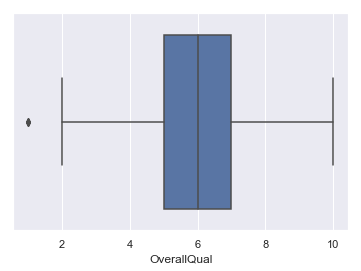

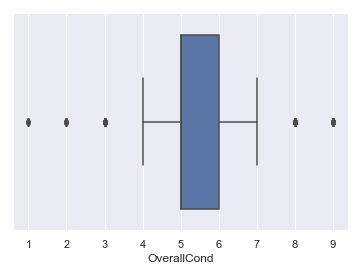

In [20]:
for i in ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']:
#        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
#        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
#        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()


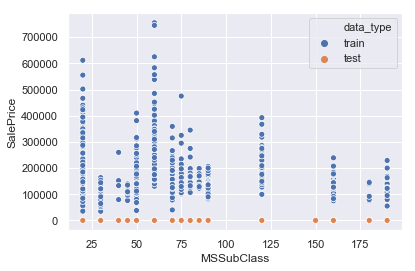

In [21]:
sns.scatterplot(all_df.MSSubClass, all_df.SalePrice,hue=all_df.data_type)

In [22]:
all_df.MSSubClass.value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

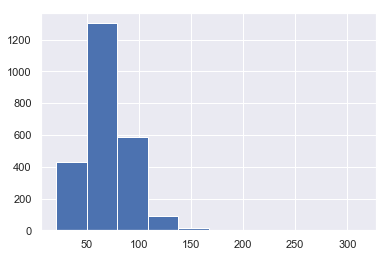

In [23]:
all_df.LotFrontage.hist()

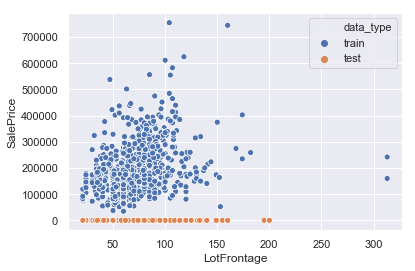

In [24]:
#### Exception case - with 310 numbers
sns.scatterplot(all_df.LotFrontage, all_df.SalePrice, hue=all_df.data_type)

In [25]:
all_df[all_df.LotFrontage>250]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
934           20       RL        313.0    27650   Pave   NaN      IR2   
1298          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
934          HLS    AllPub    Inside       Mod        NAmes       PosA   
1298         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
934        Norm     1Fam     1Story            7            7       1960   
1298       Norm     1Fam     2Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
934           2007      Flat  Tar&Grv     Wd Sdng     Wd Sdng       None   
1298          2008       Hip  ClyTile      Stucco      Stucco      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
934          0.0        TA        TA     CBlock       Gd       TA   
1298       796.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
934            Gd          GLQ       425.0          Unf         0.0   
1298           Gd          GLQ      5644.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
934       160.0        585.0    GasA        Ex          Y      SBrkr   
1298      466.0       6110.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
934       2069         0             0       2069           1.0           0.0   
1298      4692       950             0       5642           2.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
934          2         0             4             1          Gd   
1298         2         1             3             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
934              9        Typ           1          Gd     Attchd       1960.0   
1298            12        Typ           3          Gd     Attchd       2008.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
934           RFn         2.0       505.0         TA         TA          Y   
1298          Fin         2.0      1418.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
934            0            0              0          0            0   
1298         214          292              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
934          0    NaN   NaN         NaN        0      11    2008       WD   
1298       480     Gd   NaN         NaN        0       1    2008      New   

     SaleCondition  SalePrice data_type  
934         Normal     242000     train  
1298       Partial     160000     train

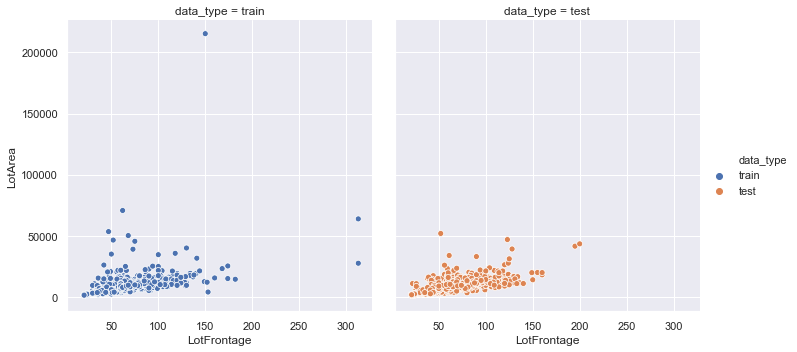

In [26]:
sns.relplot(data = all_df, x = "LotFrontage", y = "LotArea", col="data_type", hue="data_type",kind="scatter")

In [27]:
all_df[all_df.LotArea>60000]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
249           50       RL          NaN   159000   Pave   NaN      IR2   
313           20       RL        150.0   215245   Pave   NaN      IR3   
335          190       RL          NaN   164660   Grvl   NaN      IR1   
451           20       RL         62.0    70761   Pave   NaN      IR1   
706           20       RL          NaN   115149   Pave   NaN      IR2   
1298          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
249          Low    AllPub   CulDSac       Sev      ClearCr       Norm   
313          Low    AllPub    Inside       Sev       Timber       Norm   
335          HLS    AllPub    Corner       Sev       Timber       Norm   
451          Low    AllPub    Inside       Mod      ClearCr       Norm   
706          Low    AllPub   CulDSac       Sev      ClearCr       Norm   
1298         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
249        Norm     1Fam     1.5Fin            6            7       1958   
313        Norm     1Fam     1Story            7            5       1965   
335        Norm   2fmCon     1.5Fin            5            6       1965   
451        Norm     1Fam     1Story            7            5       1975   
706        Norm     1Fam     1Story            7            5       1971   
1298       Norm     1Fam     2Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
249           2006     Gable  CompShg     Wd Sdng     HdBoard     BrkCmn   
313           1965       Hip  CompShg     BrkFace     BrkFace       None   
335           1965     Gable  CompShg     Plywood     Plywood       None   
451           1975     Gable  WdShngl     Plywood     Plywood       None   
706           2002     Gable  CompShg     Plywood     Plywood      Stone   
1298          2008       Hip  ClyTile      Stucco      Stucco      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
249        472.0        Gd        TA     CBlock       Gd       TA   
313          0.0        TA        TA     CBlock       Gd       TA   
335          0.0        TA        TA     CBlock       TA       TA   
451          0.0        TA        TA     CBlock       Gd       TA   
706        351.0        TA        TA     CBlock       Gd       TA   
1298       796.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
249            Gd          Rec       697.0          Unf         0.0   
313            Gd          ALQ      1236.0          Rec       820.0   
335            Gd          ALQ      1249.0          BLQ       147.0   
451            Gd          ALQ       655.0          Unf         0.0   
706            Gd          GLQ      1219.0          Unf         0.0   
1298           Gd          GLQ      5644.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
249       747.0       1444.0    GasA        Gd          Y      SBrkr   
313        80.0       2136.0    GasW        TA          Y      SBrkr   
335       103.0       1499.0    GasA        Ex          Y      SBrkr   
451       878.0       1533.0    GasA        TA          Y      SBrkr   
706       424.0       1643.0    GasA        TA          Y      SBrkr   
1298      466.0       6110.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
249       1444       700             0       2144           0.0           1.0   
313       2036         0             0       2036           2.0           0.0   
335       1619       167             0       1786           2.0           0.0   
451       1533         0             0       1533           1.0           0.0   
706       1824   

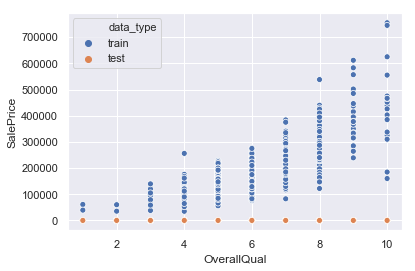

In [28]:
sns.scatterplot(all_df.OverallQual, all_df.SalePrice, hue=all_df.data_type)

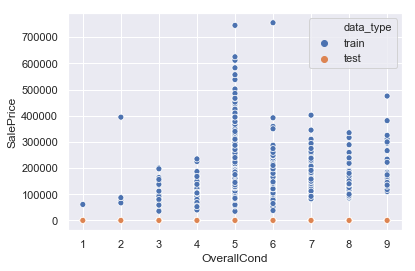

In [29]:
sns.scatterplot(all_df.OverallCond, all_df.SalePrice, hue=all_df.data_type)

In [30]:
#### Exception case
train[(train.OverallCond==2) &( train.SalePrice>300000)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
379          20       RL         88.0    11394   Pave   NaN      Reg   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                      
379         Lvl    AllPub    Corner       Gtl      StoneBr       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                        
379       Norm     1Fam     1Story            9            2       2010   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                        
379          2010       Hip  CompShg     VinylSd     VinylSd      Stone   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                              
379       350.0        Gd        TA      PConc       Ex       TA           Av   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                              
379          GLQ        1445          Unf           0        411         1856   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                              
379    GasA        Ex          Y      SBrkr      1856         0             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                             
379       1856             1             0         1         1             1   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
Id                                                                   
379             1          Ex             8        Typ           1   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
Id                                                                             
379          Ex     Attchd       2010.0          Fin           3         834   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
Id                                                                             
379         TA         TA          Y         113            0              0   

     3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  \
Id                                                                        
379          0            0         0    NaN   NaN         NaN        0   

     MoSold  YrSold SaleType SaleCondition  SalePrice data_type  
Id                                                               
379       6    2010      New       Partial     394432     train

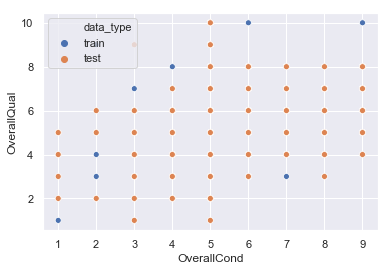

In [31]:
sns.scatterplot(all_df.OverallCond, all_df.OverallQual, hue=all_df.data_type)

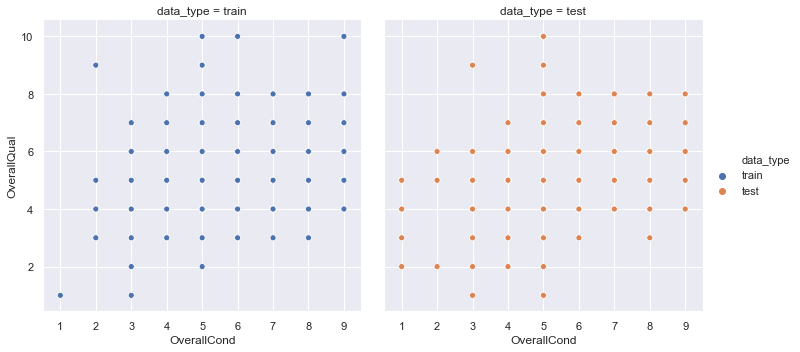

In [32]:
### Too many condition 1 items in test set
sns.relplot(data = all_df, x = "OverallCond", y = "OverallQual", col="data_type", hue="data_type",kind="scatter")

In [33]:
train[(train.OverallCond==1) &( train.OverallQual==1)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
376          30       RL          NaN    10020   Pave   NaN      IR1   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                      
376         Low    AllPub    Inside       Sev      Edwards       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                        
376       Norm     1Fam     1Story            1            1       1922   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                        
376          1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                              
376         0.0        Fa        Fa     BrkTil       Fa       Po           Gd   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                              
376          BLQ         350          Unf           0        333          683   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                              
376    GasA        Gd          N      FuseA       904         0             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                             
376        904             1             0         0         1             1   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
Id                                                                   
376             1          Fa             4       Maj1           0   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
Id                                                                             
376         NaN        NaN          NaN          NaN           0           0   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
Id                                                                             
376        NaN        NaN          Y           0            0              0   

     3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  \
Id                                                                        
376          0            0         0    NaN   NaN         NaN        0   

     MoSold  YrSold SaleType SaleCondition  SalePrice data_type  
Id                                                               
376       3    2009       WD        Normal      61000     train

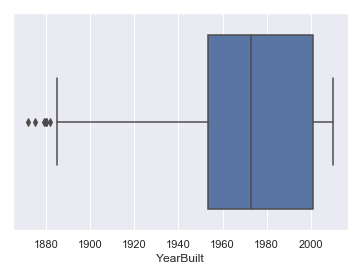

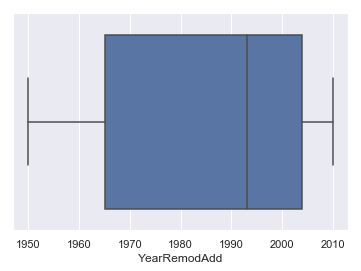

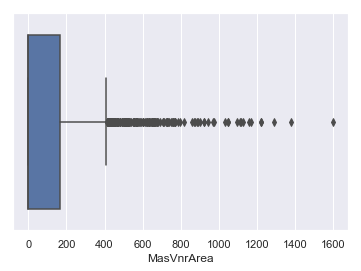

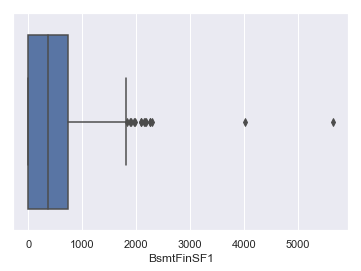

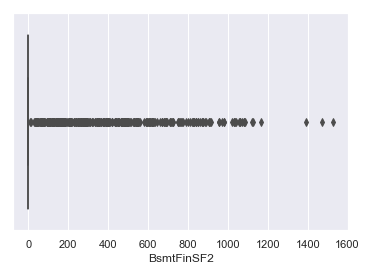

In [34]:
for i in ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']:
#        ',
#        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
#        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()



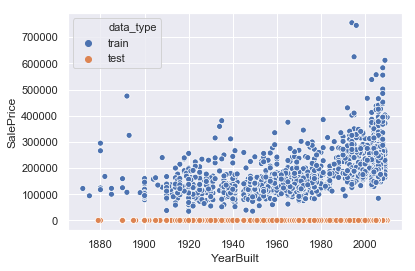

In [35]:
sns.scatterplot(all_df.YearBuilt, all_df.SalePrice, hue=all_df.data_type)

In [36]:
### Nothing odd here
train[(train.YearBuilt<=1900) &( train.SalePrice>=250000)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
186          75       RM         90.0    22950   Pave   NaN      IR2   
305          75       RM         87.0    18386   Pave   NaN      Reg   
584          75       RM         75.0    13500   Pave   NaN      Reg   
748          70       RM         65.0    11700   Pave  Pave      IR1   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                      
186         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
305         Lvl    AllPub    Inside       Gtl      OldTown       Norm   
584         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
748         Lvl    AllPub    Corner       Gtl      OldTown       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                        
186       Norm     1Fam     2.5Fin           10            9       1892   
305       Norm     1Fam     2.5Fin            7            9       1880   
584       PosA     1Fam     2.5Unf           10            9       1893   
748       Norm     1Fam     2Story            7            7       1880   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                        
186          1993     Gable  WdShngl     Wd Sdng     Wd Sdng       None   
305          2002     Gable  CompShg     CemntBd     CmentBd       None   
584          2000     Gable  CompShg     Wd Sdng     Wd Sdng       None   
748          2003   Mansard  CompShg      Stucco      Stucco       None   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                              
186         0.0        Gd        Gd     BrkTil       TA       TA           Mn   
305         0.0        TA        TA     BrkTil       TA       TA           No   
584         0.0        Ex        Ex     BrkTil       TA       TA           No   
748         0.0        Gd        TA      Stone       TA       Fa           No   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                              
186          Unf           0          Unf           0       1107         1107   
305          Unf           0          Unf           0       1470         1470   
584          Unf           0          Unf           0       1237         1237   
748          Unf           0          Unf           0       1240         1240   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                              
186    GasA        Ex          Y      SBrkr      1518      1518           572   
305    GasA        Ex          Y      SBrkr      1675      1818             0   
584    GasA        Gd          Y      SBrkr      1521      1254             0   
748    GasW        TA          N      SBrkr      1320      1320             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                             
186       3608             0             0         2         1             4   
305       3493             0             0         3         0             3   
584       2775             0             0         3         1             3   
748       2640             0             0         1         1             4   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
Id                                                                   
186             1          Ex            12        Typ           2   
305             1          Gd            10        Typ           1   
584      

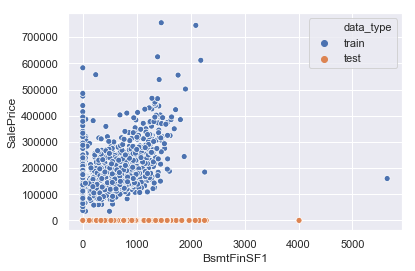

In [37]:
sns.scatterplot(all_df.BsmtFinSF1, all_df.SalePrice, hue=all_df.data_type)

In [38]:
### Something totally wrong with this - too big a house and new one for 160K
all_df[(all_df.BsmtFinSF1>=3000)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298          60       RL        313.0    63887   Pave   NaN      IR3   
2549          20       RL        128.0    39290   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1298         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   
2549         Bnk    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1298       Norm     1Fam     2Story           10            5       2008   
2549       Norm     1Fam     1Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1298          2008       Hip  ClyTile      Stucco      Stucco      Stone   
2549          2009       Hip  CompShg     CemntBd     CmentBd      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1298       796.0        Ex        TA      PConc       Ex       TA   
2549      1224.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1298           Gd          GLQ      5644.0          Unf         0.0   
2549           Gd          GLQ      4010.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1298      466.0       6110.0    GasA        Ex          Y      SBrkr   
2549     1085.0       5095.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1298      4692       950             0       5642           2.0           0.0   
2549      5095         0             0       5095           1.0           1.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1298         2         1             3             1          Ex   
2549         2         1             2             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
1298            12        Typ           3          Gd     Attchd       2008.0   
2549            15        Typ           2          Gd     Attchd       2008.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
1298          Fin         2.0      1418.0         TA         TA          Y   
2549          Fin         3.0      1154.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
1298         214          292              0          0            0   
2549         546          484              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
1298       480     Gd   NaN         NaN        0       1    2008      New   
2549         0    NaN   NaN         NaN    17000      10    2007      New   

     SaleCondition  SalePrice data_type  
1298       Partial     160000     train  
2549       Partial          0      test

In [39]:
train[(train.BsmtFinSF1>=2200)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
524           60       RL        130.0    40094   Pave   NaN      IR1   
1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
524          Bnk    AllPub    Inside       Gtl      Edwards       PosN   
1299         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                         
524        PosN     1Fam     2Story           10            5       2007   
1299       Norm     1Fam     2Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
524           2008       Hip  CompShg     CemntBd     CmentBd      Stone   
1299          2008       Hip  ClyTile      Stucco      Stucco      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
524        762.0        Ex        TA      PConc       Ex       TA   
1299       796.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
Id                                                                    
524            Gd          GLQ        2260          Unf           0   
1299           Gd          GLQ        5644          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
Id                                                                     
524         878         3138    GasA        Ex          Y      SBrkr   
1299        466         6110    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                              
524       3138      1538             0       4676             1             0   
1299      4692       950             0       5642             2             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
Id                                                                 
524          3         1             3             1          Ex   
1299         2         1             3             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
Id                                                                              
524             11        Typ           1          Gd    BuiltIn       2007.0   
1299            12        Typ           3          Gd     Attchd       2008.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
Id                                                                           
524           Fin           3         884         TA         TA          Y   
1299          Fin           2        1418         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
Id                                                                     
524          208          406              0          0            0   
1299         214          292              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
Id                                                                          
524          0    NaN   NaN         NaN        0      10    2007      New   
1299       480     Gd   NaN         NaN        0       1    2008      New   

     SaleCondition  SalePrice data_type  
Id                                       
524        Partial     184750     tra

In [40]:
test[(test.BsmtFinSF1>=3000)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2550          20       RL        128.0    39290   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
2550         Bnk    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                         
2550       Norm     1Fam     1Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
2550          2009       Hip  CompShg     CemntBd     CmentBd      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
2550      1224.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
Id                                                                    
2550           Gd          GLQ      4010.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
Id                                                                     
2550     1085.0       5095.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                              
2550      5095         0             0       5095           1.0           1.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
Id                                                                 
2550         2         1             2             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
Id                                                                              
2550            15        Typ           2          Gd     Attchd       2008.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
Id                                                                           
2550          Fin         3.0      1154.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
Id                                                                     
2550         546          484              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
Id                                                                          
2550         0    NaN   NaN         NaN    17000      10    2007      New   

     SaleCondition data_type  SalePrice  
Id                                       
2550       Partial      test          0

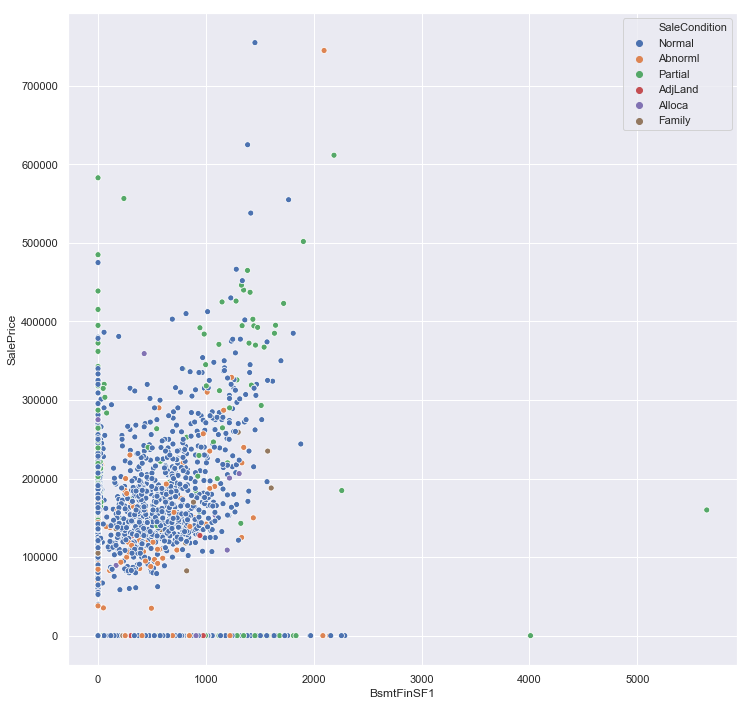

In [41]:
plt.figure(figsize=(12,12))
sns.scatterplot(all_df.BsmtFinSF1, all_df.SalePrice, hue=all_df.SaleCondition)

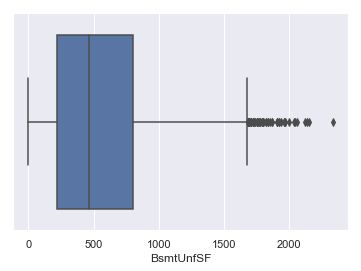

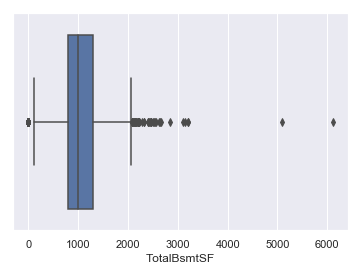

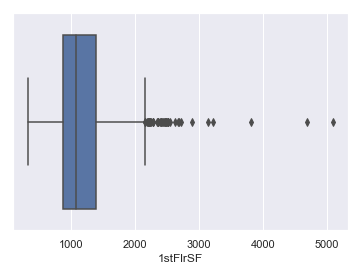

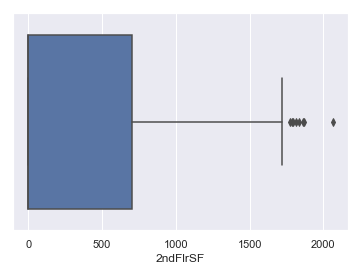

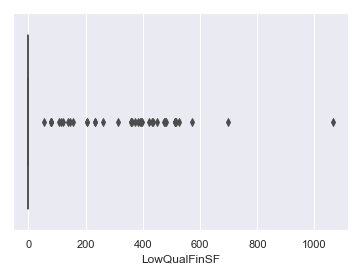

In [42]:
for i in ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']:
#        ',
#        ,
#        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

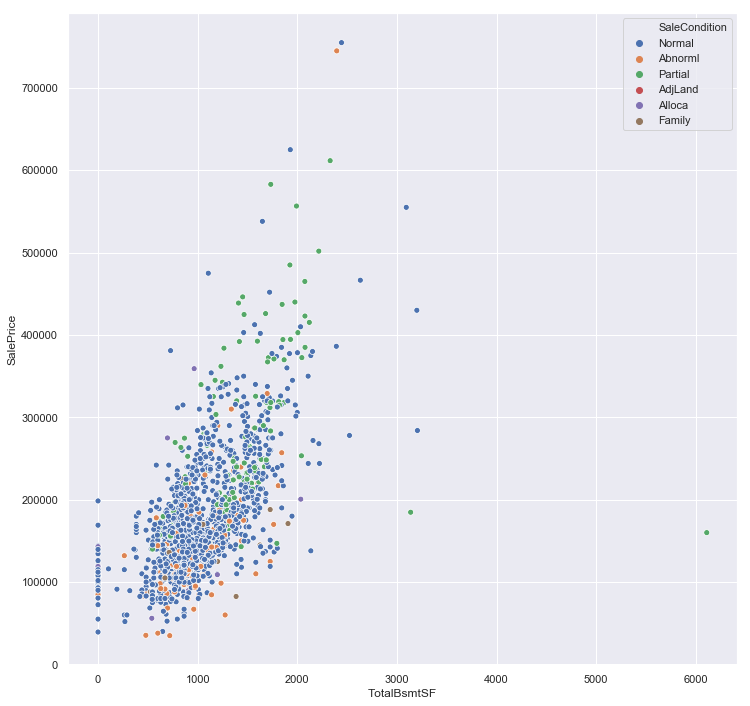

In [43]:
plt.figure(figsize=(12,12))
sns.scatterplot(train.TotalBsmtSF, train.SalePrice, hue=train.SaleCondition)

In [44]:
train[(train.TotalBsmtSF>=4000)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
1299         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                         
1299       Norm     1Fam     2Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
1299          2008       Hip  ClyTile      Stucco      Stucco      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
1299       796.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
Id                                                                    
1299           Gd          GLQ        5644          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
Id                                                                     
1299        466         6110    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                              
1299      4692       950             0       5642             2             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
Id                                                                 
1299         2         1             3             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
Id                                                                              
1299            12        Typ           3          Gd     Attchd       2008.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
Id                                                                           
1299          Fin           2        1418         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
Id                                                                     
1299         214          292              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
Id                                                                          
1299       480     Gd   NaN         NaN        0       1    2008      New   

     SaleCondition  SalePrice data_type  
Id                                       
1299       Partial     160000     train

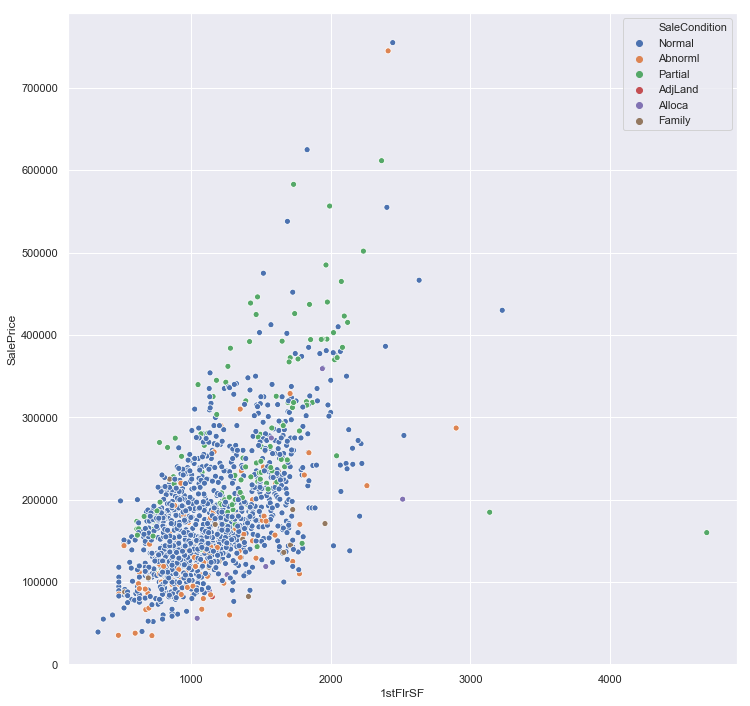

In [45]:
plt.figure(figsize=(12,12))
sns.scatterplot(train["1stFlrSF"], train.SalePrice, hue=train.SaleCondition)

In [46]:
train[(train["1stFlrSF"]>=4000)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
1299         Bnk    AllPub    Corner       Gtl      Edwards      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                         
1299       Norm     1Fam     2Story           10            5       2008   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
1299          2008       Hip  ClyTile      Stucco      Stucco      Stone   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
1299       796.0        Ex        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
Id                                                                    
1299           Gd          GLQ        5644          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
Id                                                                     
1299        466         6110    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                              
1299      4692       950             0       5642             2             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
Id                                                                 
1299         2         1             3             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
Id                                                                              
1299            12        Typ           3          Gd     Attchd       2008.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
Id                                                                           
1299          Fin           2        1418         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
Id                                                                     
1299         214          292              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
Id                                                                          
1299       480     Gd   NaN         NaN        0       1    2008      New   

     SaleCondition  SalePrice data_type  
Id                                       
1299       Partial     160000     train

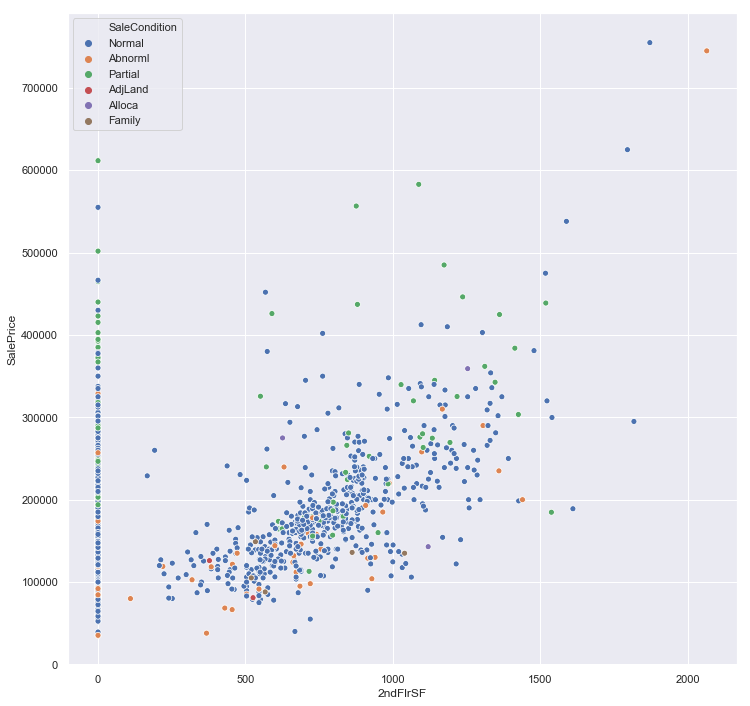

In [47]:
#### Exception : Very few values - remove the column
plt.figure(figsize=(12,12))
sns.scatterplot(train["2ndFlrSF"], train.SalePrice, hue=train.SaleCondition)

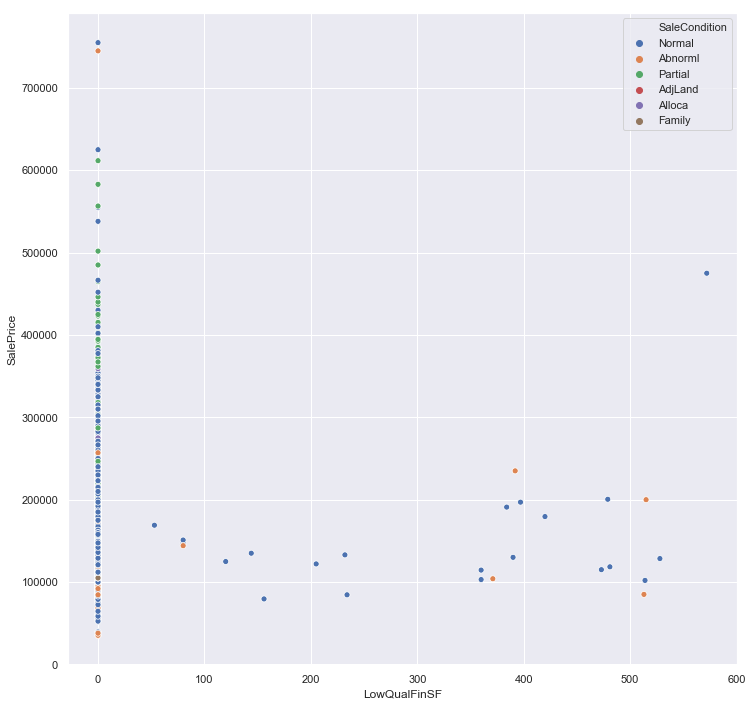

In [48]:
plt.figure(figsize=(12,12))
sns.scatterplot(train.LowQualFinSF, train.SalePrice, hue=train.SaleCondition)

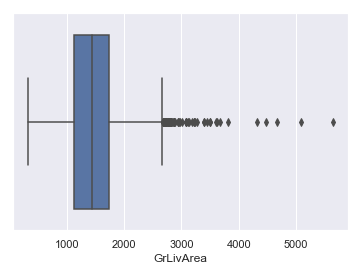

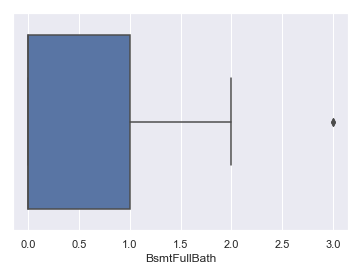

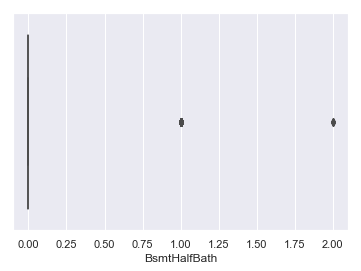

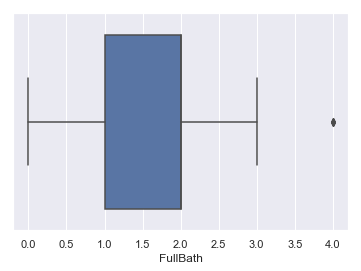

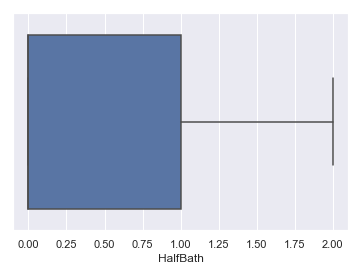

In [49]:
for i in ['GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']:
#        ',
#        ,
#        ,
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

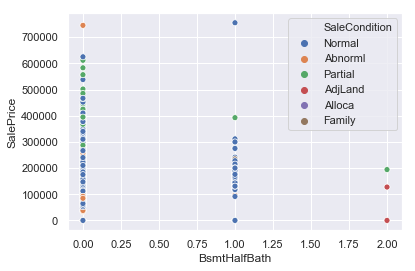

In [50]:
sns.scatterplot(all_df.BsmtHalfBath, all_df.SalePrice, hue=all_df.SaleCondition)

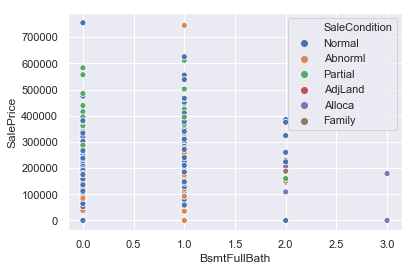

In [51]:
sns.scatterplot(all_df.BsmtFullBath, all_df.SalePrice, hue=all_df.SaleCondition)

In [52]:
### Exception
train[(train.BsmtFullBath==3)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
739          90       RL         60.0    10800   Pave   NaN      Reg   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                      
739         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                        
739       Norm   Duplex     1Story            5            5       1987   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                        
739          1988     Gable  CompShg     Plywood     Plywood       None   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                              
739         0.0        TA        TA     CBlock       Gd       Gd           Gd   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                              
739          GLQ        1200          Unf           0          0         1200   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                              
739    GasA        TA          Y      SBrkr      1200         0             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                             
739       1200             3             0         3         0             3   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
Id                                                                   
739             1          TA             5        Typ           0   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
Id                                                                             
739         NaN        NaN          NaN          NaN           0           0   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
Id                                                                             
739        NaN        NaN          Y         120            0              0   

     3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  \
Id                                                                        
739          0            0         0    NaN   NaN         NaN        0   

     MoSold  YrSold SaleType SaleCondition  SalePrice data_type  
Id                                                               
739       3    2009       WD        Alloca     179000     train

In [53]:
all_df[(all_df.BsmtFullBath==3)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
738           90       RL         60.0    10800   Pave   NaN      Reg   
1839          90       RL         60.0    10800   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
738          Lvl    AllPub    Inside       Gtl      Edwards       Norm   
1839         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
738        Norm   Duplex     1Story            5            5       1987   
1839       Norm   Duplex     1Story            5            5       1987   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
738           1988     Gable  CompShg     Plywood     Plywood       None   
1839          1988     Gable  CompShg     Plywood     Plywood       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
738          0.0        TA        TA     CBlock       Gd       Gd   
1839         0.0        TA        Gd     CBlock       Gd       Gd   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
738            Gd          GLQ      1200.0          Unf         0.0   
1839           Gd          GLQ      1200.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
738         0.0       1200.0    GasA        TA          Y      SBrkr   
1839        0.0       1200.0    GasA        TA          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
738       1200         0             0       1200           3.0           0.0   
1839      1200         0             0       1200           3.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
738          3         0             3             1          TA   
1839         3         0             3             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
738              5        Typ           0         NaN        NaN          NaN   
1839             5        Typ           0         NaN        NaN          NaN   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
738           NaN         0.0         0.0        NaN        NaN          Y   
1839          NaN         0.0         0.0        NaN        NaN          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
738          120            0              0          0            0   
1839         120            0              0          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
738          0    NaN   NaN         NaN        0       3    2009       WD   
1839         0    NaN   NaN         NaN        0       3    2009       WD   

     SaleCondition  SalePrice data_type  
738         Alloca     179000     train  
1839        Alloca          0      test

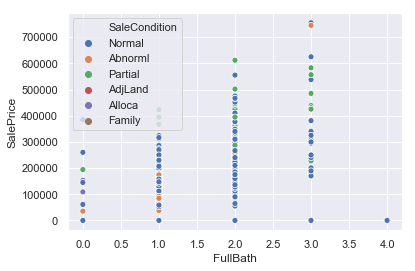

In [54]:
sns.scatterplot(all_df.FullBath, all_df.SalePrice, hue=all_df.SaleCondition)

In [55]:
### Exception - combine the bathroom count
### Seems duplexes have bathrooms in basement
### All in test data
all_df[(all_df.FullBath==4)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1619          90       RL         70.0     7700   Pave   NaN      Reg   
1861          90       RL          NaN    11855   Pave   NaN      Reg   
1862          90       RL          NaN     7939   Pave   NaN      Reg   
1863          90       RL          NaN     7976   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1619         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
1861         Lvl    AllPub    Inside       Gtl      SawyerW       Norm   
1862         Lvl    AllPub    Inside       Gtl      SawyerW      Feedr   
1863         Lvl    AllPub    Inside       Gtl      SawyerW      Feedr   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1619       Norm   Duplex     2Story            5            2       1985   
1861       Norm   Duplex     2Story            7            5       2000   
1862       Norm   Duplex     2Story            7            5       2000   
1863       Norm   Duplex     2Story            7            5       2000   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1619          1986     Gable  CompShg     HdBoard     HdBoard       None   
1861          2000       Hip  CompShg     VinylSd     VinylSd    BrkFace   
1862          2000       Hip  CompShg     VinylSd     VinylSd    BrkFace   
1863          2000       Hip  CompShg     VinylSd     VinylSd    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1619         0.0        TA        Po      PConc       TA       TA   
1861        23.0        TA        TA      PConc       Ex       TA   
1862        23.0        TA        TA      PConc       Ex       TA   
1863        23.0        TA        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1619           No          Unf         0.0          Unf         0.0   
1861           No          GLQ       820.0          Unf         0.0   
1862           No          GLQ       820.0          Unf         0.0   
1863           No          GLQ       820.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1619     1216.0       1216.0    GasA        Gd          Y      SBrkr   
1861      348.0       1168.0    GasA        Ex          Y      SBrkr   
1862      348.0       1168.0    GasA        Ex          Y      SBrkr   
1863      348.0       1168.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1619      1216      1216             0       2432           0.0           0.0   
1861      1168      1619             0       2787           2.0           0.0   
1862      1168      1619             0       2787           2.0           0.0   
1863      1168      1619             0       2787           2.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1619         4         2             4             2          TA   
1861         4         2             6             2          TA   
1862         4         2             6             2          TA   
1863         4         2             6             2          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
1619            10        Typ           0         NaN     Attchd       1985.0   
1861             8        Typ           2          TA    BuiltIn       2000.0   
1862             8        Typ           2          TA    BuiltIn       2000.0   
1863             8        Typ           2          TA    BuiltIn       2000.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
1619          Unf         2.0       616.0         TA         Fa          Y   
1861          Fin         4.0       820.0         TA         TA          Y   
1862          Fin         4.0       820.0         TA     

In [56]:
all_df.head(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   
5          50       RL         85.0    14115   Pave   NaN      IR1   
6          20       RL         75.0    10084   Pave   NaN      Reg   
7          60       RL          NaN    10382   Pave   NaN      IR1   
8          50       RM         51.0     6120   Pave   NaN      Reg   
9         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
7         Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
9         Lvl    AllPub    Corner       Gtl      BrkSide     Artery   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   
5       Norm     1Fam     1.5Fin            5            5       1993   
6       Norm     1Fam     1Story            8            5       2004   
7       Norm     1Fam     2Story            7            6       1973   
8       Norm     1Fam     1.5Fin            7            5       1931   
9     Artery   2fmCon     1.5Unf            5            6       1939   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1995     Gable  CompShg     VinylSd     VinylSd       None   
6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   
7          1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8          1950     Gable  CompShg     BrkFace     Wd Shng       None   
9          1950     Gable  CompShg     MetalSd     MetalSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   
5         0.0        TA        TA       Wood       Gd       TA           No   
6       186.0        Gd        TA      PConc       Ex       TA           Av   
7       240.0        TA        TA     CBlock       Gd       TA           Mn   
8         0.0        TA        TA     BrkTil       TA       TA           No   
9         0.0        TA        TA     BrkTil       T

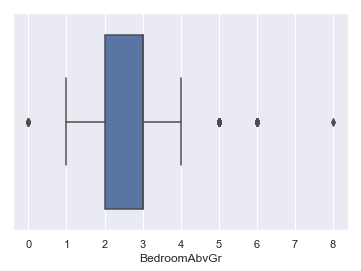

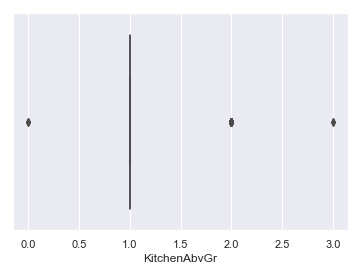

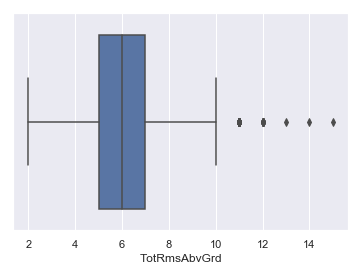

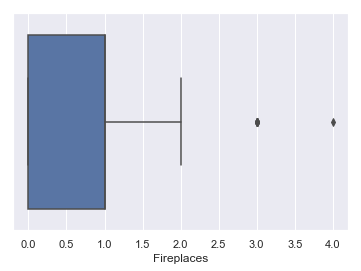

In [57]:
for i in ['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']:
#        ',
#        ,
#        ,
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

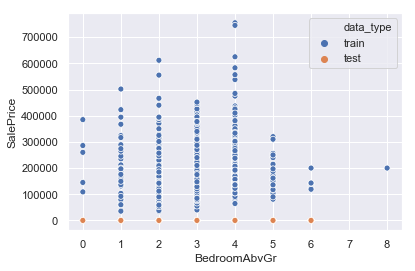

In [58]:
sns.scatterplot(all_df.BedroomAbvGr, all_df.SalePrice, hue=all_df.data_type)

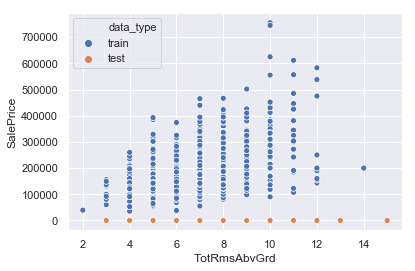

In [59]:
sns.scatterplot(all_df.TotRmsAbvGrd, all_df.SalePrice, hue=all_df.data_type)

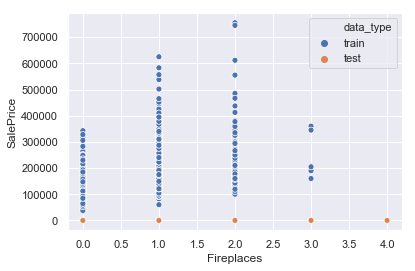

In [60]:
### Exception 4 fire places in test data
sns.scatterplot(all_df.Fireplaces, all_df.SalePrice, hue=all_df.data_type)

In [61]:
all_df[(all_df.Fireplaces==4)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2710          80       RL        100.0    14330   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
2710         Low    AllPub    Corner       Gtl      Veenker       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
2710       Norm     1Fam       SLvl            7            4       1974   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
2710          1974     Gable  CompShg     WdShing     Wd Sdng    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
2710       145.0        Gd        Fa     CBlock       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
2710           Gd          ALQ      1023.0          BLQ       497.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
2710      228.0       1748.0    GasA        Gd          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
2710      2151       495             0       2646           1.0           2.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
2710         2         0             3             1          Gd   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
2710             9        Mod           4          TA     Attchd       1974.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
2710          RFn         2.0       550.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
2710         641          100              0          0            0   

      PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
2710       800     Gd  GdPrv         NaN        0       1    2006       WD   

     SaleCondition  SalePrice data_type  
2710        Normal          0      test

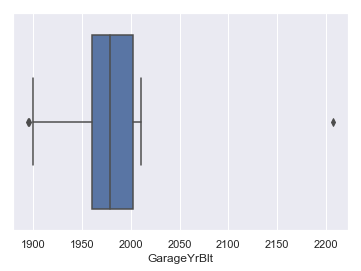

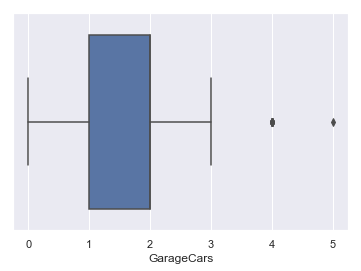

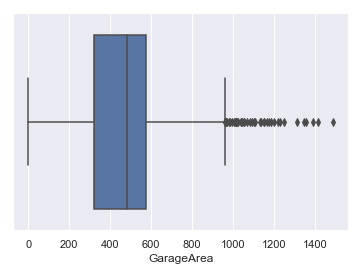

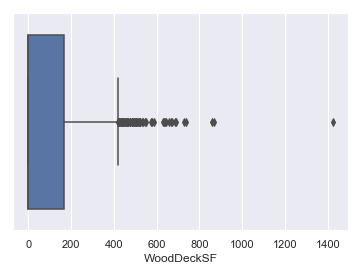

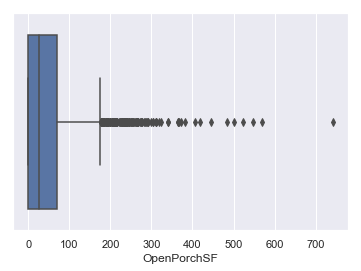

In [62]:
for i in ['GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']:
#        ',
#        ,
#        ,
#        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#        ',
#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

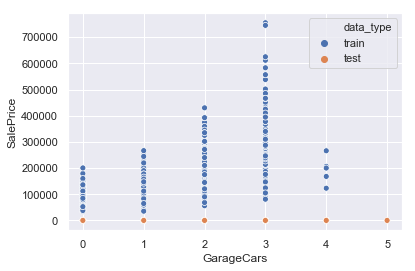

In [63]:
sns.scatterplot(all_df.GarageCars, all_df.SalePrice, hue=all_df.data_type)

In [64]:
### Exception
all_df[(all_df.GarageCars==5)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1828          30       RM         50.0     8635   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1828         Lvl    AllPub    Inside       Gtl      BrkSide       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1828       Norm     1Fam     1Story            5            5       1925   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1828          1950       Hip  CompShg     Wd Sdng     Wd Sdng       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1828         0.0        TA        Fa     BrkTil       TA       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1828           No          LwQ       134.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1828      938.0       1072.0    GasA        TA          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1828      1072         0             0       1072           1.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1828         1         0             2             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
1828             5        Typ           0         NaN     Detchd       1982.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
1828          Unf         5.0      1184.0         Fa         TA          P   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
1828           0            0            105          0            0   

      PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
1828         0    NaN   NaN         NaN        0       8    2009       WD   

     SaleCondition  SalePrice data_type  
1828        Normal          0      test

In [65]:
### Too many test cases with 4 garages
all_df[(all_df.GarageCars==4)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
420           90       RM         78.0     7060   Pave   NaN      Reg   
747           70       RM         65.0    11700   Pave  Pave      IR1   
1190         190       RL          NaN    32463   Pave   NaN      Reg   
1340          20       RL         70.0     8294   Pave   NaN      Reg   
1350          90       RL         91.0    11643   Pave   NaN      Reg   
1575          60       RL         87.0    12361   Pave   NaN      IR1   
1861          90       RL          NaN    11855   Pave   NaN      Reg   
1862          90       RL          NaN     7939   Pave   NaN      Reg   
1863          90       RL          NaN     7976   Pave   NaN      Reg   
1955          60       RL          NaN    12511   Pave   NaN      IR1   
1970          60       RL         96.0    12539   Pave   NaN      Reg   
2071          50       RL         60.0    10836   Pave  Grvl      Reg   
2237          90       RM         97.0     8940   Pave   NaN      IR1   
2599          20       RL        200.0    43500   Pave   NaN      Reg   
2828          90       RL         73.0     9069   Pave   NaN      Reg   
2905          90       RM         78.0     7020   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
420          Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
747          Lvl    AllPub    Corner       Gtl      OldTown       Norm   
1190         Low    AllPub    Inside       Mod      Mitchel       Norm   
1340         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1350         Lvl    AllPub    Inside       Gtl        NAmes     Artery   
1575         Lvl    AllPub   CulDSac       Gtl      SawyerW       Norm   
1861         Lvl    AllPub    Inside       Gtl      SawyerW       Norm   
1862         Lvl    AllPub    Inside       Gtl      SawyerW      Feedr   
1863         Lvl    AllPub    Inside       Gtl      SawyerW      Feedr   
1955         Lvl    AllPub    Corner       Gtl       NWAmes       Norm   
1970         Lvl    AllPub    Inside       Gtl      NridgHt       PosN   
2071         Lvl    AllPub    Inside       Gtl      OldTown       Norm   
2237         Lvl    AllPub    Corner       Gtl      Mitchel       Norm   
2599         Lvl    AllPub    Inside       Gtl      Mitchel     Artery   
2828         Lvl    AllPub    Inside       Gtl      SawyerW       Norm   
2905         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
420        Norm   Duplex     SFoyer            7            5       1997   
747        Norm     1Fam     2Story            7            7       1880   
1190       Norm   2fmCon     1Story            4            4       1961   
1340       Norm     1Fam     1Story            4            5       1971   
1350       Norm   Duplex     2Story            5            5       1969   
1575       Norm     1Fam     2Story            6            7       1993   
1861       Norm   Duplex     2Story            7            5       2000   
1862       Norm   Duplex     2Story            7            5       2000   
1863       Norm   Duplex     2Story            7            5       2000   
1955       Norm     1Fam     2Story            7            7       1978   
1970       Norm     1Fam     2Story           10            5       2005   
2071       Norm     1Fam     1.5Fin            5            5       1922   
2237       Norm   Duplex     SFoyer            7            5       1997   
2599       Norm     1Fam     1Story            3            5       1953   
2828       Norm   Duplex     SFoyer            6            8       1993   
2905       Norm   Duplex     SFoyer            7            5       1997   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
420           1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
747           2003   Mansard  CompShg      Stucco      Stucc

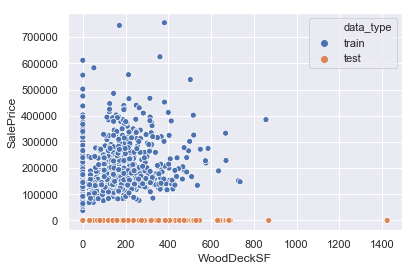

In [66]:
### Exception in test 
sns.scatterplot(all_df.WoodDeckSF, all_df.SalePrice, hue=all_df.data_type)

In [67]:
all_df[(all_df.WoodDeckSF>800)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
53            20       RL         68.0    50271   Pave   NaN      IR1   
2606          80       RL          NaN    15957   Pave   NaN      IR1   
2682          60       RL        114.0    17242   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
53           Low    AllPub    Inside       Gtl      Veenker       Norm   
2606         Low    AllPub    Corner       Mod      Mitchel       Norm   
2682         Lvl    AllPub    Inside       Gtl      NoRidge       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
53         Norm     1Fam     1Story            9            5       1981   
2606       Norm     1Fam       SLvl            6            6       1977   
2682       Norm     1Fam     2Story            9            5       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
53            1987     Gable  WdShngl     WdShing     Wd Shng       None   
2606          1977     Gable  CompShg     HdBoard     Plywood       None   
2682          1994       Hip  CompShg     MetalSd     MetalSd    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
53           0.0        Gd        TA     CBlock       Ex       TA   
2606         0.0        TA        TA      PConc       Gd       TA   
2682       738.0        Gd        Gd      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
53             Gd          GLQ      1810.0          Unf         0.0   
2606           Gd          GLQ      1148.0          Unf         0.0   
2682           Gd          Rec       292.0          GLQ      1393.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
53         32.0       1842.0    GasA        Gd          Y      SBrkr   
2606       96.0       1244.0    GasA        TA          Y      SBrkr   
2682       48.0       1733.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
53        1842         0             0       1842           2.0           0.0   
2606      1356         0             0       1356           2.0           0.0   
2682      1933      1567             0       3500           1.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
53           0         1             0             1          Gd   
2606         2         0             3             1          TA   
2682         3         1             4             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
53               5        Typ           1          Gd     Attchd       1981.0   
2606             6        Typ           1          TA     Attchd       1977.0   
2682            11        Typ           1          TA     Attchd       1993.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
53            Fin         3.0       894.0         TA         TA          Y   
2606          Fin         2.0       528.0         TA         TA          Y   
2682          RFn         3.0       959.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
53           857           72              0          0            0   
2606        1424            0              0          0            0   
2682         870           86              0          0          210   

      PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
53           0    NaN    NaN         NaN        0      11    2006       WD   
2606         0    NaN  MnPrv         NaN        0       9    2007       WD   
2682         0    NaN    NaN         NaN        0       5    2006       WD   

     SaleCondition  SalePrice data_type  
53          Normal     385000     train  
2606        Normal          0    

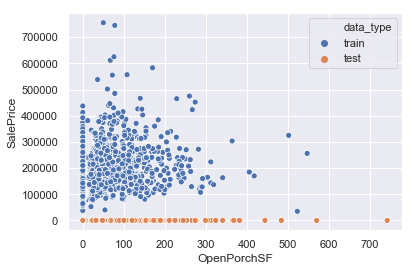

In [68]:
### Another testy exception
sns.scatterplot(all_df.OpenPorchSF, all_df.SalePrice, hue=all_df.data_type)

In [69]:
all_df[(all_df.OpenPorchSF>520)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
495           30  C (all)         60.0     7879   Pave   NaN      Reg   
1328          50       RM         60.0    10440   Pave  Grvl      Reg   
2486          60       RL         99.0    16779   Pave   NaN      Reg   
2557          90       RL         60.0    10890   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
495          Lvl    AllPub    Inside       Gtl       IDOTRR       Norm   
1328         Lvl    AllPub    Corner       Gtl      OldTown       Norm   
2486         Lvl    AllPub    Inside       Gtl       Sawyer      Feedr   
2557         Lvl    AllPub    Inside       Gtl        SWISU       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
495        Norm     1Fam     1Story            4            5       1920   
1328       Norm     1Fam     1.5Fin            6            7       1920   
2486       Norm     1Fam     2Story            5            4       1920   
2557       Norm   Duplex     2Story            5            6       1923   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
495           1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   
1328          1950     Gable  CompShg     BrkFace     Wd Sdng       None   
2486          1996     Gable  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2557          1950       Hip  CompShg     Wd Sdng     Plywood       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
495          0.0        TA        TA     CBlock       TA       TA   
1328         0.0        Gd        Gd     BrkTil       Gd       TA   
2486       356.0        TA        Fa     CBlock       Gd       TA   
2557         0.0        TA        TA      PConc       TA       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
495            No          Rec       495.0          Unf         0.0   
1328           No          LwQ       493.0          Unf         0.0   
2486           No          BLQ       267.0          Unf         0.0   
2557           Mn          Rec       371.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
495       225.0        720.0    GasA        TA          N      FuseA   
1328     1017.0       1510.0    GasW        Ex          Y      SBrkr   
2486      404.0        671.0    GasA        Fa          Y      SBrkr   
2557      925.0       1296.0    Grav        Fa          N      FuseA   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
495        720         0             0        720           0.0           0.0   
1328      1584      1208             0       2792           0.0           0.0   
2486      1567      1087             0       2654           0.0           0.0   
2557      1296      1296             0       2592           2.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
495          1         0             2             1          TA   
1328         2         0             5             1          TA   
2486         3         0             4             1          TA   
2557         2         0             6             2          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
495              4        Typ           0         NaN        NaN          NaN   
1328             8        Mod           2          TA     Detchd       1920.0   
2486            11        Mod           1          Gd     Attchd       1946.0   
2557            12       Min2           0         NaN        NaN          NaN   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
495           NaN         0.0         0.0        NaN        NaN          N   
1328          Unf         2.0       520.0         Fa         TA          Y   
2486          Unf         2.0       638.0         TA     

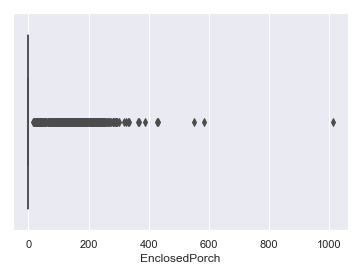

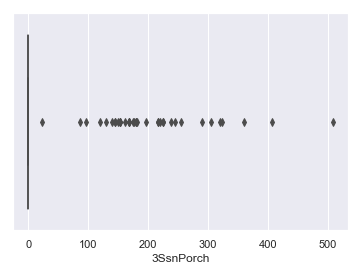

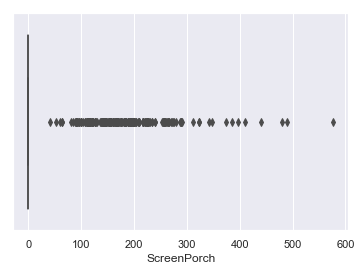

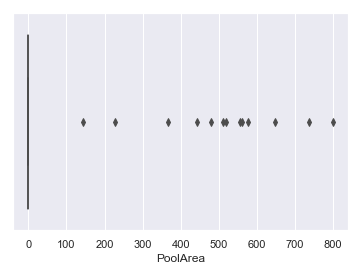

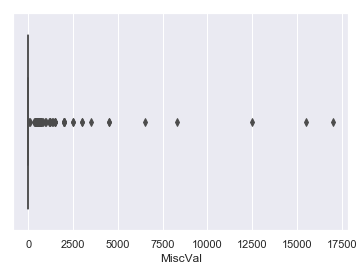

In [70]:
for i in ['EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']:

#        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
#        'MoSold', 'YrSold', 'SalePrice']:
    sns.boxplot(all_df[i])
    plt.show()

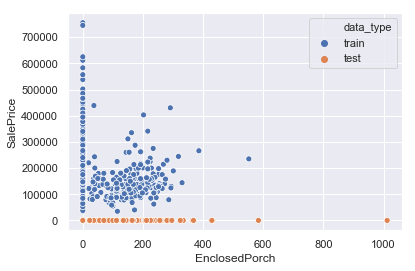

In [71]:
sns.scatterplot(all_df.EnclosedPorch, all_df.SalePrice, hue=all_df.data_type)

In [72]:
### Exceptions in test
all_df[(all_df.EnclosedPorch>400)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
197           75       RL        174.0    25419   Pave   NaN      Reg   
1785          50       RL         60.0    10410   Pave  Grvl      Reg   
2503          50       RL        104.0    23920   Pave   NaN      Reg   
2567          20       RL          NaN    25485   Pave   NaN      IR1   
2880          50       RL         66.0    21780   Pave   NaN      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
197          Lvl    AllPub    Corner       Gtl        NAmes     Artery   
1785         Lvl    AllPub    Inside       Gtl      OldTown       Norm   
2503         Lvl    AllPub    Inside       Gtl      SawyerW      Feedr   
2567         Lvl    AllPub   CulDSac       Gtl      Crawfor       Norm   
2880         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
197        Norm     1Fam     2Story            8            4       1918   
1785       Norm     1Fam     1.5Fin            4            5       1915   
2503       Norm     1Fam     1.5Fin            6            5       1984   
2567       Norm     1Fam     1Story            6            4       1960   
2880       Norm     1Fam     2Story            6            5       1920   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
197           1990     Gable  CompShg      Stucco      Stucco       None   
1785          1950     Gable  CompShg     MetalSd     MetalSd       None   
2503          1984     Gable  CompShg     Wd Sdng     Wd Sdng       None   
2567          1960     Gable  CompShg     Wd Sdng     MetalSd    BrkFace   
2880          1950     Gable  CompShg     Wd Sdng     Wd Shng       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
197          0.0        Gd        Gd      PConc       TA       TA   
1785         0.0        TA        TA     BrkTil       TA       TA   
2503         0.0        TA        TA     CBlock       TA       TA   
2567       423.0        TA        Fa     CBlock       TA       Gd   
2880         0.0        TA        TA      PConc       TA       Fa   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
197            No          GLQ      1036.0          LwQ       184.0   
1785           No          Unf         0.0          Unf         0.0   
2503           No          Unf         0.0          Unf         0.0   
2567           Mn          LwQ       540.0          Rec      1020.0   
2880           No          Unf         0.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
197       140.0       1360.0    GasA        Gd          Y      SBrkr   
1785     1313.0       1313.0    GasA        TA          Y      SBrkr   
2503     1105.0       1105.0    GasA        Ex          Y      SBrkr   
2567        0.0       1560.0    GasA        TA          Y      SBrkr   
2880      817.0        817.0    GasA        Gd          Y      FuseF   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
197       1360      1360           392       3112           1.0           1.0   
1785      1313         0          1064       2377           0.0           0.0   
2503      1105       717             0       1822           0.0           0.0   
2567      1560         0             0       1560           0.0           0.0   
2880       940       610             0       1550           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
197          2         0             4             1          Gd   
1785         2         0             3             1          Gd   
2503         2         0             4             1          Gd   
2567         1         1             3             1          TA   
2880         1         1             3             1          TA   

      TotRmsAbvGrd Functional  Firepl

In [73]:
all_df[(all_df.EnclosedPorch>400)].EnclosedPorch.value_counts()

432     1
429     1
1012    1
584     1
552     1
Name: EnclosedPorch, dtype: int64

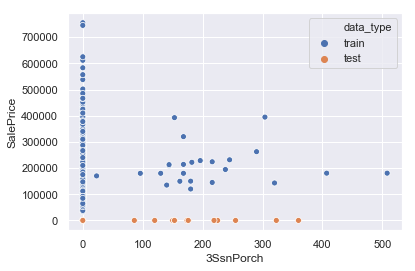

In [74]:
sns.scatterplot(all_df["3SsnPorch"], all_df.SalePrice, hue=all_df.data_type)

In [75]:
all_df[(all_df["3SsnPorch"]>400)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
55           20       RL        100.0    10175   Pave   NaN      IR1   
205          20       RL         99.0    11851   Pave   NaN      Reg   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
55          Lvl    AllPub    Inside       Gtl        NAmes       Norm   
205         Lvl    AllPub    Corner       Gtl      Gilbert       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
55        Norm     1Fam     1Story            6            5       1964   
205       Norm     1Fam     1Story            7            5       1990   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
55           1964     Gable  CompShg     HdBoard     Plywood    BrkFace   
205          1990     Gable  CompShg     HdBoard     HdBoard       None   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
55        272.0        TA        TA     CBlock       TA       TA           No   
205         0.0        TA        TA      PConc       Gd       TA           No   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
55           BLQ       490.0          Unf         0.0      935.0       1425.0   
205          Unf         0.0          Unf         0.0     1424.0       1424.0   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
55     GasA        Gd          Y      SBrkr      1425         0             0   
205    GasA        Ex          Y      SBrkr      1442         0             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
55        1425           0.0           0.0         2         0             3   
205       1442           0.0           0.0         2         0             3   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
55              1          TA             7        Typ           1   
205             1          TA             5        Typ           0   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
55           Gd     Attchd       1964.0          RFn         2.0       576.0   
205         NaN     Attchd       1990.0          RFn         2.0       500.0   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
55          TA         TA          Y           0            0              0   
205         TA         TA          Y           0           34              0   

     3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  \
55         407            0         0    NaN   NaN         NaN        0   
205        508            0         0    NaN   NaN         NaN        0   

     MoSold  YrSold SaleType SaleCondition  SalePrice data_type  
55        7    2008       WD        Normal     180500     train  
205       5    2009       WD        Normal     180500     train

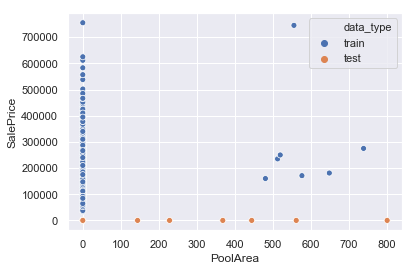

In [76]:
### Highest val in test case
### both on high side and low side
sns.scatterplot(all_df.PoolArea, all_df.SalePrice, hue=all_df.data_type)

In [77]:
all_df[(all_df.PoolArea>600)]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
810           20       RL         78.0    10140   Pave   NaN      Reg   
1423          80       RL          NaN    19690   Pave   NaN      IR1   
2710          80       RL        100.0    14330   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
810          Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1423         Lvl    AllPub   CulDSac       Gtl      Edwards       Norm   
2710         Low    AllPub    Corner       Gtl      Veenker       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
810        Norm     1Fam     1Story            6            6       1974   
1423       Norm     1Fam       SLvl            6            7       1966   
2710       Norm     1Fam       SLvl            7            4       1974   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
810           1999       Hip  CompShg     HdBoard     HdBoard    BrkFace   
1423          1966      Flat  Tar&Grv     Plywood     Plywood       None   
2710          1974     Gable  CompShg     WdShing     Wd Sdng    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
810         99.0        TA        TA     CBlock       TA       TA   
1423         0.0        Gd        Gd     CBlock       Gd       TA   
2710       145.0        Gd        Fa     CBlock       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
810            No          ALQ       663.0          LwQ       377.0   
1423           Av          Unf         0.0          Unf         0.0   
2710           Gd          ALQ      1023.0          BLQ       497.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
810         0.0       1040.0    GasA        Fa          Y      SBrkr   
1423      697.0        697.0    GasA        TA          Y      SBrkr   
2710      228.0       1748.0    GasA        Gd          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
810       1309         0             0       1309           1.0           0.0   
1423      1575       626             0       2201           0.0           0.0   
2710      2151       495             0       2646           1.0           2.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
810          1         1             3             1          Gd   
1423         2         0             4             1          Gd   
2710         2         0             3             1          Gd   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
810              5        Typ           1          Fa     Attchd       1974.0   
1423             8        Typ           1          Gd     Attchd       1966.0   
2710             9        Mod           4          TA     Attchd       1974.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
810           RFn         2.0       484.0         TA         TA          Y   
1423          Unf         2.0       432.0         Gd         Gd          Y   
2710          RFn         2.0       550.0         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
810          265            0              0          0            0   
1423         586          236              0          0            0   
2710         641          100              0          0            0   

      PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
810        648     Fa  GdPrv         NaN        0       1    2006       WD   
1423       738     Gd  GdPrv         NaN        0       8    2006       WD   
2710       800     Gd  GdPrv         NaN        0       1    2006       WD   

     SaleCondition  SalePrice data_type  
810         Normal     181000     train  
1423        Alloca     274970    

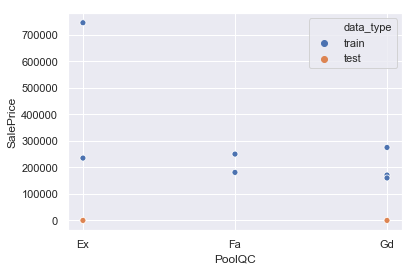

In [78]:
sns.scatterplot(all_df.PoolQC, all_df.SalePrice, hue=all_df.data_type)

In [79]:
### Exception - shud drop all pool columns and replace with Pool Y/N
all_df[all_df.PoolArea == 0].PoolArea.count()

2906

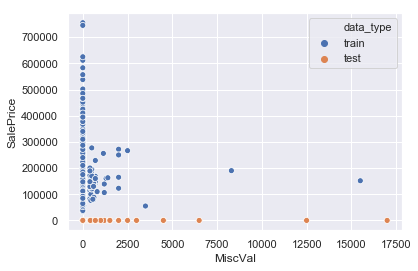

In [80]:
sns.scatterplot(all_df.MiscVal, all_df.SalePrice, hue=all_df.data_type)

In [81]:
### Get rid of this - too few values
all_df.MiscVal.value_counts()

0        2816
400        18
500        13
450         9
600         8
700         7
2000        7
650         3
1200        3
1500        3
4500        2
2500        2
480         2
3000        2
12500       1
300         1
350         1
8300        1
420         1
80          1
54          1
460         1
490         1
3500        1
560         1
17000       1
15500       1
750         1
800         1
900         1
1000        1
1150        1
1300        1
1400        1
1512        1
6500        1
455         1
620         1
Name: MiscVal, dtype: int64

In [82]:
all_df.MiscFeature.value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [83]:
all_df.shape

(2919, 81)

In [84]:
print(all_df[all_df.MiscVal != 0][["MiscVal", "MiscFeature"]])

      MiscVal MiscFeature
5         700        Shed
7         350        Shed
16        700        Shed
17        500        Shed
51        400        Shed
84        700        Shed
95        480        Shed
98        400        Shed
99        400        Shed
106       450        Shed
214       450        Shed
249       500        Shed
250       450        Shed
335       700        Shed
338       400        Shed
346     15500        Gar2
392      1200        Shed
439       800        Shed
499       480        Shed
502       400        Shed
510      2000        Shed
539      2000        Shed
589       600        Shed
611       500        Shed
626       600        Shed
634       600        Shed
705      3500        Othr
725       500        Shed
733       400        Shed
760       450        Shed
766       500        Shed
767      1300        Shed
786      1200        Shed
794       500        Shed
800       400        Shed
812        54        Shed
813       500        Shed
867       40

data_type  MSZoning
test       RL          1114
           RM           242
           FV            74
           C (all)       15
           RH            10
train      RL          1151
           RM           218
           FV            65
           RH            16
           C (all)       10
Name: MSZoning, dtype: int64


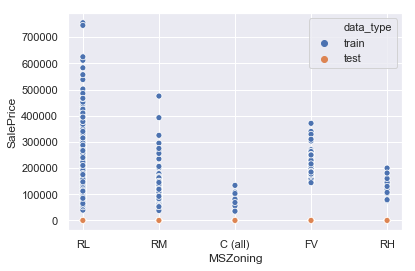

data_type  Street
test       Pave      1453
           Grvl         6
train      Pave      1454
           Grvl         6
Name: Street, dtype: int64


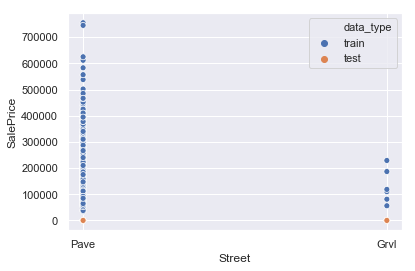

data_type  Alley
test       Grvl     70
           Pave     37
train      Grvl     50
           Pave     41
Name: Alley, dtype: int64


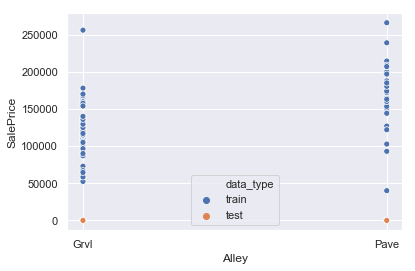

data_type  LotShape
test       Reg         934
           IR1         484
           IR2          35
           IR3           6
train      Reg         925
           IR1         484
           IR2          41
           IR3          10
Name: LotShape, dtype: int64


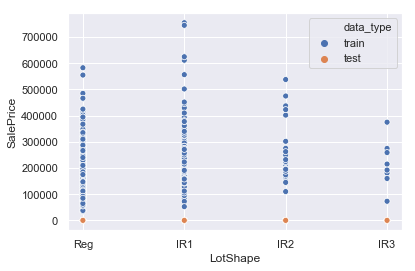

data_type  LandContour
test       Lvl            1311
           HLS              70
           Bnk              54
           Low              24
train      Lvl            1311
           Bnk              63
           HLS              50
           Low              36
Name: LandContour, dtype: int64


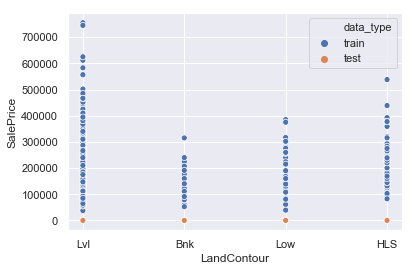

data_type  Utilities
test       AllPub       1457
train      AllPub       1459
           NoSeWa          1
Name: Utilities, dtype: int64


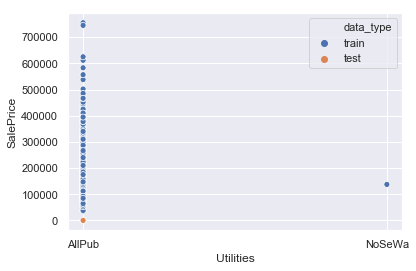

data_type  LotConfig
test       Inside       1081
           Corner        248
           CulDSac        82
           FR2            38
           FR3            10
train      Inside       1052
           Corner        263
           CulDSac        94
           FR2            47
           FR3             4
Name: LotConfig, dtype: int64


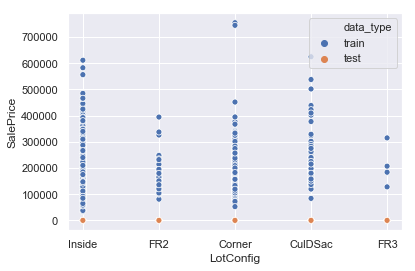

data_type  LandSlope
test       Gtl          1396
           Mod            60
           Sev             3
train      Gtl          1382
           Mod            65
           Sev            13
Name: LandSlope, dtype: int64


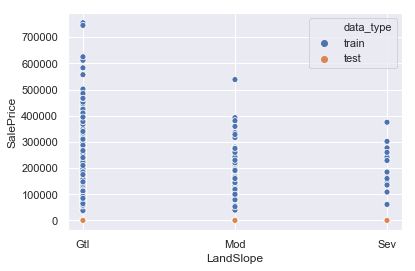

data_type  Neighborhood
test       NAmes           218
           OldTown         126
           CollgCr         117
           Somerst          96
           Edwards          94
           NridgHt          89
           Gilbert          86
           Sawyer           77
           SawyerW          66
           Mitchel          65
           NWAmes           58
           IDOTRR           56
           Crawfor          52
           BrkSide          50
           Timber           34
           NoRidge          30
           StoneBr          26
           SWISU            23
           MeadowV          20
           ClearCr          16
           BrDale           14
           NPkVill          14
           Veenker          13
           Blmngtn          11
           Blueste           8
train      NAmes           225
           CollgCr         150
           OldTown         113
           Edwards         100
           Somerst          86
           Gilbert          79
           Nrid

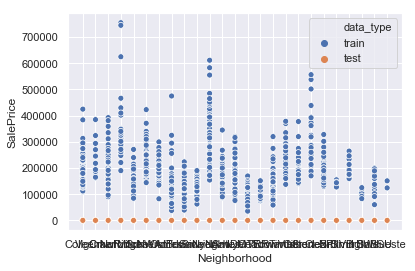

data_type  Condition1
test       Norm          1251
           Feedr           83
           Artery          44
           RRAn            24
           PosN            20
           RRAe            17
           PosA            12
           RRNe             4
           RRNn             4
train      Norm          1260
           Feedr           81
           Artery          48
           RRAn            26
           PosN            19
           RRAe            11
           PosA             8
           RRNn             5
           RRNe             2
Name: Condition1, dtype: int64


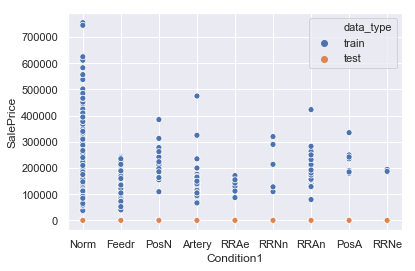

data_type  Condition2
test       Norm          1444
           Feedr            7
           Artery           3
           PosA             3
           PosN             2
train      Norm          1445
           Feedr            6
           Artery           2
           PosN             2
           RRNn             2
           PosA             1
           RRAe             1
           RRAn             1
Name: Condition2, dtype: int64


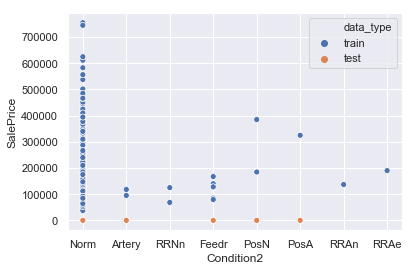

data_type  BldgType
test       1Fam        1205
           TwnhsE       113
           Duplex        57
           Twnhs         53
           2fmCon        31
train      1Fam        1220
           TwnhsE       114
           Duplex        52
           Twnhs         43
           2fmCon        31
Name: BldgType, dtype: int64


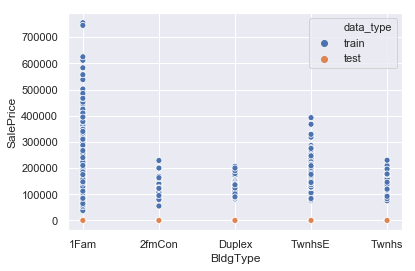

data_type  HouseStyle
test       1Story        745
           2Story        427
           1.5Fin        160
           SLvl           63
           SFoyer         46
           2.5Unf         13
           1.5Unf          5
train      1Story        726
           2Story        445
           1.5Fin        154
           SLvl           65
           SFoyer         37
           1.5Unf         14
           2.5Unf         11
           2.5Fin          8
Name: HouseStyle, dtype: int64


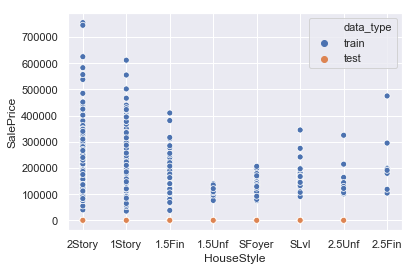

data_type  RoofStyle
test       Gable        1169
           Hip           265
           Gambrel        11
           Flat            7
           Mansard         4
           Shed            3
train      Gable        1141
           Hip           286
           Flat           13
           Gambrel        11
           Mansard         7
           Shed            2
Name: RoofStyle, dtype: int64


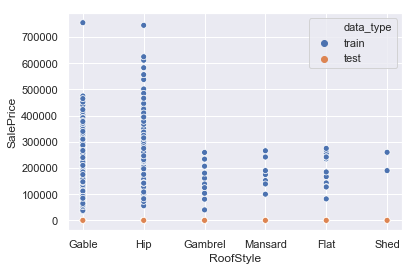

data_type  RoofMatl
test       CompShg     1442
           Tar&Grv       12
           WdShake        4
           WdShngl        1
train      CompShg     1434
           Tar&Grv       11
           WdShngl        6
           WdShake        5
           ClyTile        1
           Membran        1
           Metal          1
           Roll           1
Name: RoofMatl, dtype: int64


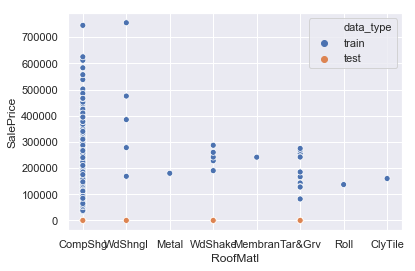

data_type  Exterior1st
test       VinylSd        510
           MetalSd        230
           HdBoard        220
           Wd Sdng        205
           Plywood        113
           CemntBd         65
           BrkFace         37
           WdShing         30
           AsbShng         24
           Stucco          18
           BrkComm          4
           AsphShn          1
           CBlock           1
train      VinylSd        515
           HdBoard        222
           MetalSd        220
           Wd Sdng        206
           Plywood        108
           CemntBd         61
           BrkFace         50
           WdShing         26
           Stucco          25
           AsbShng         20
           BrkComm          2
           Stone            2
           AsphShn          1
           CBlock           1
           ImStucc          1
Name: Exterior1st, dtype: int64


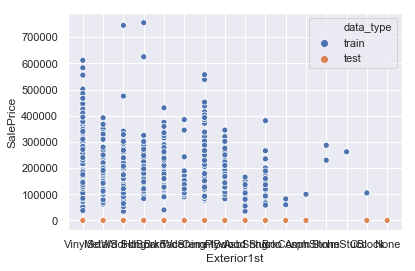

data_type  Exterior2nd
test       VinylSd        510
           MetalSd        233
           HdBoard        199
           Wd Sdng        194
           Plywood        128
           CmentBd         66
           Wd Shng         43
           BrkFace         22
           Stucco          21
           AsbShng         18
           Brk Cmn         15
           ImStucc          5
           CBlock           2
           AsphShn          1
           Stone            1
train      VinylSd        504
           MetalSd        214
           HdBoard        207
           Wd Sdng        197
           Plywood        142
           CmentBd         60
           Wd Shng         38
           Stucco          26
           BrkFace         25
           AsbShng         20
           ImStucc         10
           Brk Cmn          7
           Stone            5
           AsphShn          3
           CBlock           1
           Other            1
Name: Exterior2nd, dtype: int64


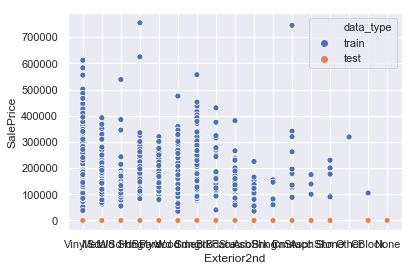

data_type  MasVnrType
test       None          878
           BrkFace       434
           Stone         121
           BrkCmn         10
train      None          864
           BrkFace       445
           Stone         128
           BrkCmn         15
Name: MasVnrType, dtype: int64


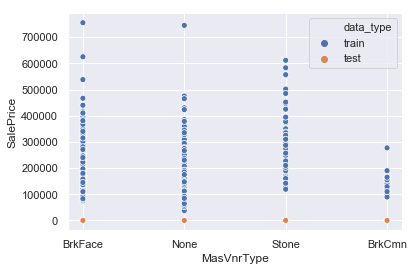

data_type  ExterQual
test       TA           892
           Gd           491
           Ex            55
           Fa            21
train      TA           906
           Gd           488
           Ex            52
           Fa            14
Name: ExterQual, dtype: int64


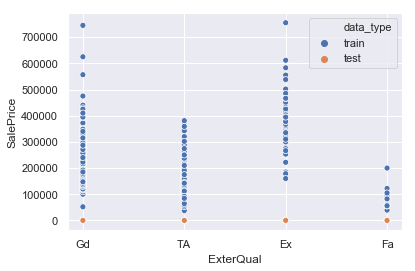

data_type  ExterCond
test       TA           1256
           Gd            153
           Fa             39
           Ex              9
           Po              2
train      TA           1282
           Gd            146
           Fa             28
           Ex              3
           Po              1
Name: ExterCond, dtype: int64


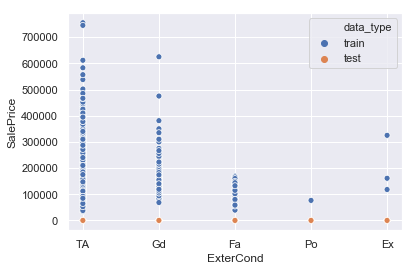

data_type  Foundation
test       PConc         661
           CBlock        601
           BrkTil        165
           Slab           25
           Stone           5
           Wood            2
train      PConc         647
           CBlock        634
           BrkTil        146
           Slab           24
           Stone           6
           Wood            3
Name: Foundation, dtype: int64


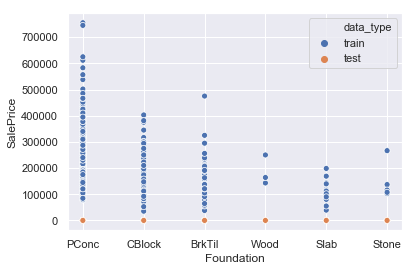

data_type  BsmtQual
test       TA          634
           Gd          591
           Ex          137
           Fa           53
train      TA          649
           Gd          618
           Ex          121
           Fa           35
Name: BsmtQual, dtype: int64


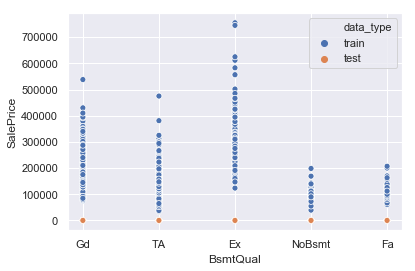

data_type  BsmtCond
test       TA          1295
           Fa            59
           Gd            57
           Po             3
train      TA          1311
           Gd            65
           Fa            45
           Po             2
Name: BsmtCond, dtype: int64


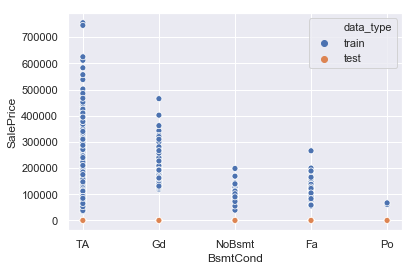

data_type  BsmtExposure
test       No              951
           Av              197
           Gd              142
           Mn              125
train      No              953
           Av              221
           Gd              134
           Mn              114
Name: BsmtExposure, dtype: int64


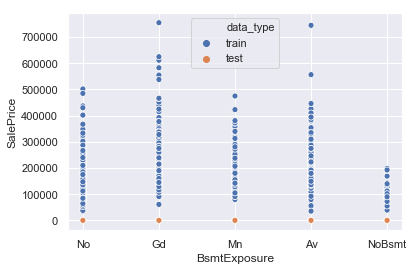

data_type  BsmtFinType1
test       GLQ             431
           Unf             421
           ALQ             209
           Rec             155
           BLQ             121
           LwQ              80
train      Unf             430
           GLQ             418
           ALQ             220
           BLQ             148
           Rec             133
           LwQ              74
Name: BsmtFinType1, dtype: int64


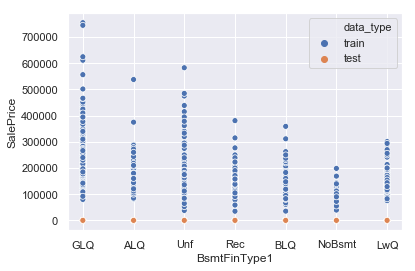

data_type  BsmtFinType2
test       Unf             1237
           Rec               51
           LwQ               41
           BLQ               35
           ALQ               33
           GLQ               20
train      Unf             1256
           Rec               54
           LwQ               46
           BLQ               33
           ALQ               19
           GLQ               14
Name: BsmtFinType2, dtype: int64


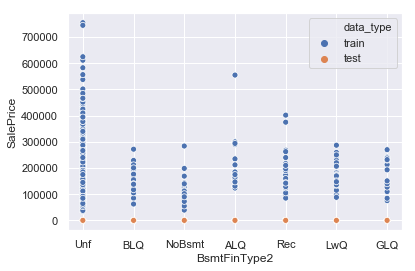

data_type  Heating
test       GasA       1446
           GasW          9
           Grav          2
           Wall          2
train      GasA       1428
           GasW         18
           Grav          7
           Wall          4
           OthW          2
           Floor         1
Name: Heating, dtype: int64


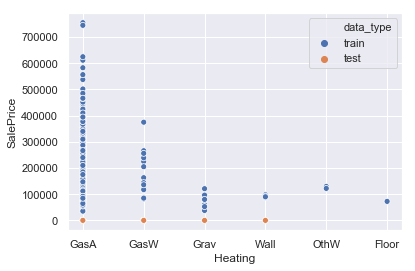

data_type  HeatingQC
test       Ex           752
           TA           429
           Gd           233
           Fa            43
           Po             2
train      Ex           741
           TA           428
           Gd           241
           Fa            49
           Po             1
Name: HeatingQC, dtype: int64


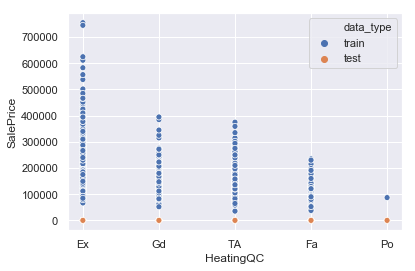

data_type  CentralAir
test       Y             1358
           N              101
train      Y             1365
           N               95
Name: CentralAir, dtype: int64


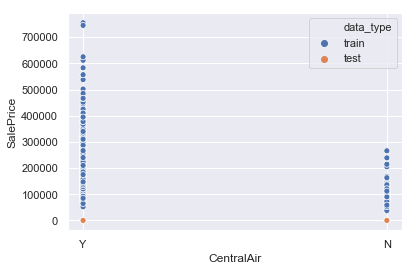

data_type  Electrical
test       SBrkr         1337
           FuseA           94
           FuseF           23
           FuseP            5
train      SBrkr         1334
           FuseA           94
           FuseF           27
           FuseP            3
           Mix              1
Name: Electrical, dtype: int64


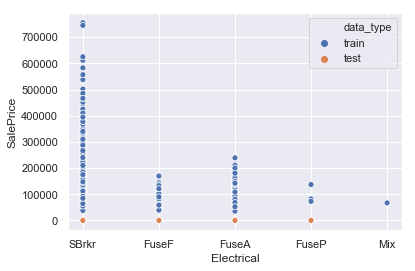

data_type  KitchenQual
test       TA             757
           Gd             565
           Ex             105
           Fa              31
train      TA             735
           Gd             586
           Ex             100
           Fa              39
Name: KitchenQual, dtype: int64


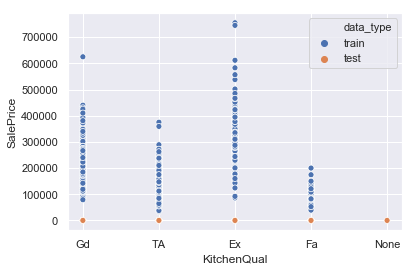

data_type  Functional
test       Typ           1357
           Min2            36
           Min1            34
           Mod             20
           Maj1             5
           Maj2             4
           Sev              1
train      Typ           1360
           Min2            34
           Min1            31
           Mod             15
           Maj1            14
           Maj2             5
           Sev              1
Name: Functional, dtype: int64


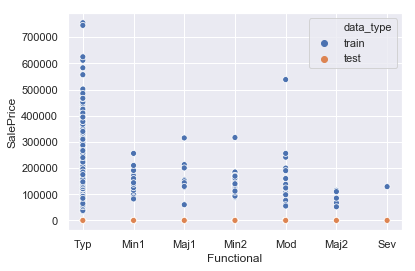

data_type  FireplaceQu
test       Gd             364
           TA             279
           Fa              41
           Po              26
           Ex              19
train      Gd             380
           TA             313
           Fa              33
           Ex              24
           Po              20
Name: FireplaceQu, dtype: int64


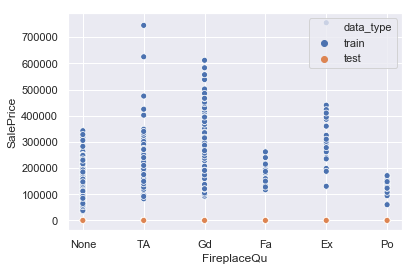

data_type  GarageType
test       Attchd        853
           Detchd        392
           BuiltIn        98
           2Types         17
           Basment        17
           CarPort         6
train      Attchd        870
           Detchd        387
           BuiltIn        88
           Basment        19
           CarPort         9
           2Types          6
Name: GarageType, dtype: int64


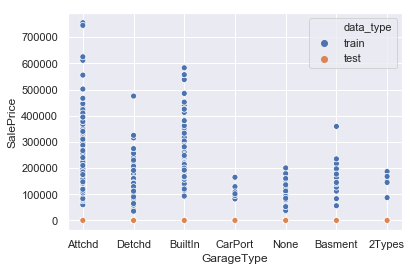

data_type  GarageFinish
test       Unf             625
           RFn             389
           Fin             367
train      Unf             605
           RFn             422
           Fin             352
Name: GarageFinish, dtype: int64


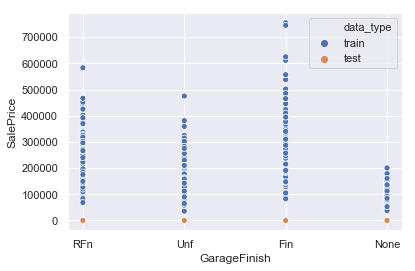

data_type  GarageQual
test       TA            1293
           Fa              76
           Gd              10
           Po               2
train      TA            1311
           Fa              48
           Gd              14
           Ex               3
           Po               3
Name: GarageQual, dtype: int64


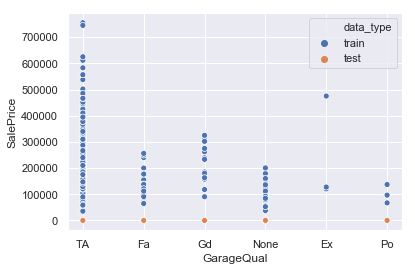

data_type  GarageCond
test       TA            1328
           Fa              39
           Po               7
           Gd               6
           Ex               1
train      TA            1326
           Fa              35
           Gd               9
           Po               7
           Ex               2
Name: GarageCond, dtype: int64


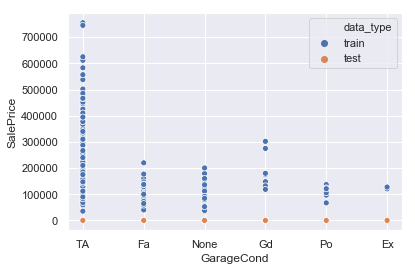

data_type  PavedDrive
test       Y             1301
           N              126
           P               32
train      Y             1340
           N               90
           P               30
Name: PavedDrive, dtype: int64


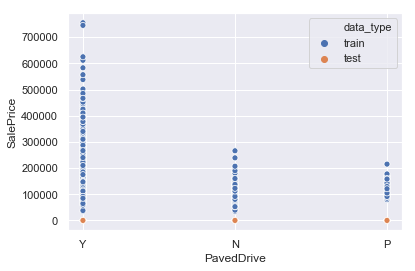

data_type  PoolQC
test       Ex        2
           Gd        1
train      Gd        3
           Ex        2
           Fa        2
Name: PoolQC, dtype: int64


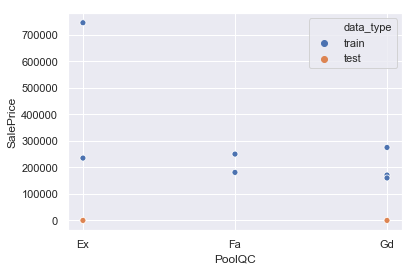

data_type  Fence
test       MnPrv    172
           GdPrv     59
           GdWo      58
           MnWw       1
train      MnPrv    157
           GdPrv     59
           GdWo      54
           MnWw      11
Name: Fence, dtype: int64


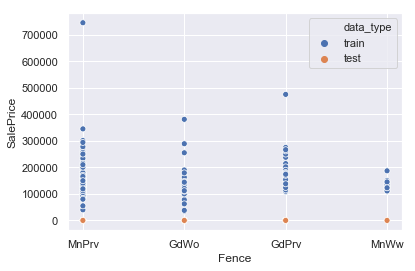

data_type  MiscFeature
test       Shed           46
           Gar2            3
           Othr            2
train      Shed           49
           Gar2            2
           Othr            2
           TenC            1
Name: MiscFeature, dtype: int64


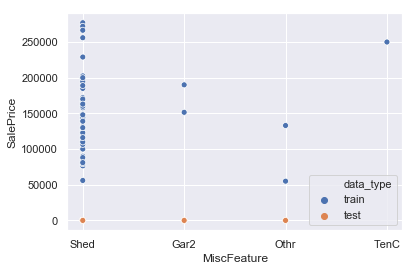

data_type  SaleType
test       WD          1258
           New          117
           COD           44
           ConLD         17
           CWD            8
           ConLI          4
           Oth            4
           Con            3
           ConLw          3
train      WD          1267
           New          122
           COD           43
           ConLD          9
           ConLI          5
           ConLw          5
           CWD            4
           Oth            3
           Con            2
Name: SaleType, dtype: int64


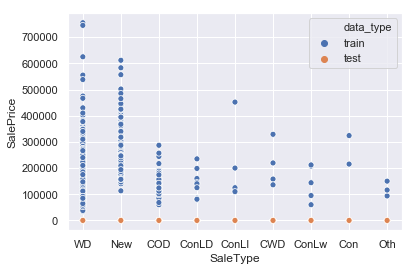

data_type  SaleCondition
test       Normal           1204
           Partial           120
           Abnorml            89
           Family             26
           Alloca             12
           AdjLand             8
train      Normal           1198
           Partial           125
           Abnorml           101
           Family             20
           Alloca             12
           AdjLand             4
Name: SaleCondition, dtype: int64


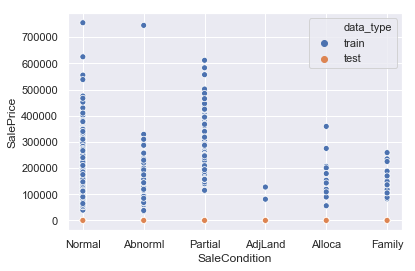

data_type  data_type
test       test         1459
train      train        1460
Name: data_type, dtype: int64


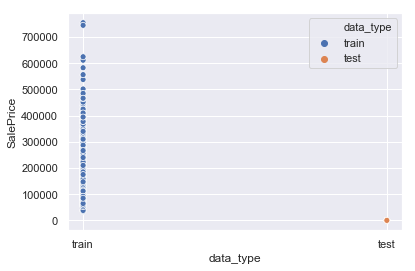

In [85]:
for i in cat_cols: 
    print(all_df.groupby("data_type")[i].value_counts())
    sns.scatterplot(fin_df[i], fin_df.SalePrice, hue=fin_df.data_type)    
    plt.show()


# Trying Transformation

In [86]:
all_df["Electrical"].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [87]:
all_df["Electrical"] = np.where(all_df["Electrical"].str.contains("SBrkr"), 1, 0)

In [88]:
all_df["Electrical"].value_counts()

1    2672
0     247
Name: Electrical, dtype: int64

In [89]:
all_df["Heating"].value_counts()

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

In [90]:
all_df["Heating"] = np.where(all_df["Heating"].str.contains("GasA"), 1, 0)

In [91]:
all_df["Heating"].value_counts()

1    2874
0      45
Name: Heating, dtype: int64

In [92]:
all_df["RoofMatl"].value_counts()

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Membran       1
ClyTile       1
Metal         1
Roll          1
Name: RoofMatl, dtype: int64

In [93]:
all_df["RoofMatl"] = np.where(all_df["RoofMatl"].str.contains("CompShg|WdShngl", regex=True), True, False)

In [94]:
all_df["RoofMatl"].value_counts()

True     2883
False      36
Name: RoofMatl, dtype: int64

In [95]:
all_df["RoofMatl"].dtype

dtype('bool')

In [96]:
xx = pd.get_dummies(all_df[["RoofMatl"]])
xx.head()

RoofMatl
0      True
1      True
2      True
3      True
4      True

In [97]:
all_df["RoofMatl"] = np.where(all_df["RoofMatl"].str.contains("CompShg|WdShngl", regex=True), "1", "0")
xx = pd.get_dummies(all_df[["RoofMatl"]])
xx.head()

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [98]:
train,test,all_df,fin_df = process_raw_data()



*****
 Processing raw files to generate processed files... hold tight...


*****
Loading test and train data....
Train Data Shape : (1460, 81)
Test Data Shape :  (1459, 81)
Combined Data Shape :  (2919, 81)


*****
Printing stats...
No of rows :  2919
No of columns :  81
Numeric columns :  37
Non Numeric columns :  44


Null counts :
              NA Count   PERCENT
Column                          
MSZoning           4.0  0.001370
LotFrontage      486.0  0.166495
Alley           2721.0  0.932169
Utilities          2.0  0.000685
Exterior1st        1.0  0.000343
Exterior2nd        1.0  0.000343
MasVnrType        24.0  0.008222
MasVnrArea        23.0  0.007879
BsmtQual          81.0  0.027749
BsmtCond          82.0  0.028092
BsmtExposure      82.0  0.028092
BsmtFinType1      79.0  0.027064
BsmtFinSF1         1.0  0.000343
BsmtFinType2      80.0  0.027407
BsmtFinSF2         1.0  0.000343
BsmtUnfSF          1.0  0.000343
TotalBsmtSF        1.0  0.000343
Electrical         1.0  0.000343
Bs

In [99]:
all_df["TotalFullBaths"] = all_df["BsmtFullBath"]+all_df["FullBath"]



In [100]:
all_df["TotalHalfBaths"] = all_df["BsmtHalfBath"]+all_df["HalfBath"]



In [101]:
all_df.loc[all_df.EnclosedPorch>400, "EnclosedPorch"] = 380 + np.random.randint(0,20,5)



In [102]:
all_df[(all_df.EnclosedPorch>=380)].EnclosedPorch.value_counts()

389    1
398    1
397    1
386    1
385    1
390    1
Name: EnclosedPorch, dtype: int64

data_type  MSSubClass
test       20            543
           60            276
           50            143
           120            95
           30             70
           70             68
           160            65
           80             60
           90             57
           190            31
           85             28
           75              7
           180             7
           45              6
           40              2
           150             1
train      20            536
           60            299
           50            144
           120            87
           30             69
           160            63
           70             60
           80             58
           90             52
           190            30
           85             20
           75             16
           45             12
           180            10
           40              4
Name: MSSubClass, dtype: int64


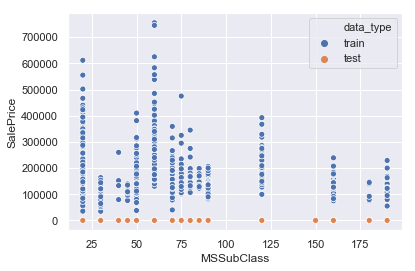

data_type  LotFrontage
test       60.0           133
           80.0            68
           70.0            63
           50.0            60
           75.0            52
           65.0            49
           85.0            36
           24.0            30
           63.0            30
           21.0            27
           68.0            25
           64.0            24
           74.0            24
           90.0            23
           62.0            22
           72.0            22
           78.0            21
           82.0            16
           73.0            15
           52.0            14
           53.0            14
           56.0            14
           57.0            14
           59.0            14
           76.0            14
           51.0            12
           81.0            12
           88.0            12
           100.0           12
           43.0            11
           66.0            11
           79.0            11
           35.0  

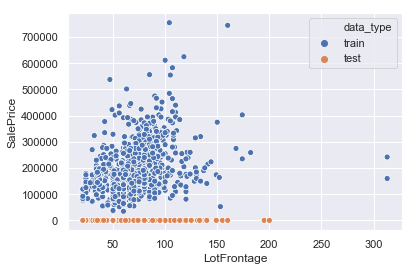

data_type  LotArea
test       9600       20
           7200       18
           6000       17
           9000       15
           7500       12
           10800      11
           6240       10
           6120        9
           7000        9
           1680        8
           8000        7
           8400        7
           9750        7
           10320       7
           2280        6
           8640        6
           10400       6
           5400        5
           8750        5
           9350        5
           9900        5
           11050       5
           1890        4
           5000        4
           8050        4
           8064        4
           8125        4
           8250        4
           9100        4
           9316        4
           10000       4
           10200       4
           13072       4
           2544        3
           3675        3
           3907        3
           4800        3
           7150        3
           7175        3
      

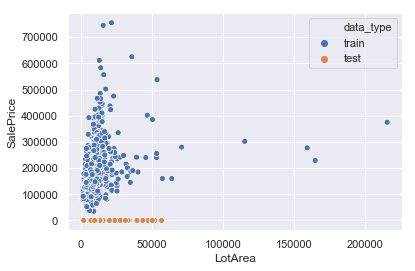

data_type  OverallQual
test       5              428
           6              357
           7              281
           8              174
           4              110
           9               64
           3               20
           10              13
           2               10
           1                2
train      5              397
           6              374
           7              319
           8              168
           4              116
           9               43
           3               20
           10              18
           2                3
           1                2
Name: OverallQual, dtype: int64


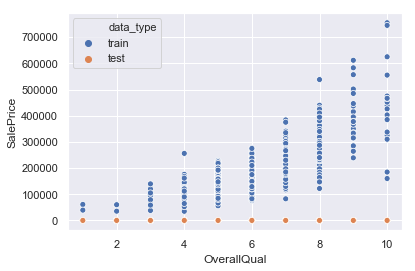

data_type  OverallCond
test       5              824
           6              279
           7              185
           8               72
           4               44
           3               25
           9               19
           1                6
           2                5
train      5              821
           6              252
           7              205
           8               72
           4               57
           3               25
           9               22
           2                5
           1                1
Name: OverallCond, dtype: int64


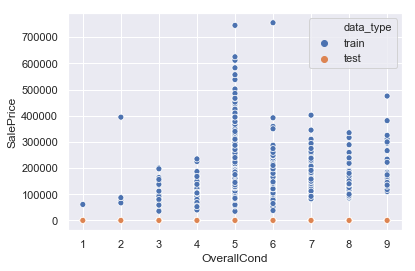

data_type  YearBuilt
test       2005         78
           2006         71
           2007         60
           2004         45
           2003         43
           1920         27
           1999         27
           1910         26
           2008         26
           1956         25
           1967         25
           1977         25
           1958         24
           2000         24
           2002         24
           1968         23
           1978         23
           1993         22
           1976         21
           1997         21
           1998         21
           1960         20
           1961         20
           1900         19
           1954         19
           1963         19
           1996         19
           1925         18
           1940         18
           1950         18
           1955         18
           1964         18
           1970         18
           1994         18
           1930         17
           1959         17
       

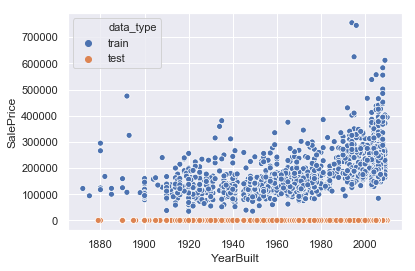

data_type  YearRemodAdd
test       1950            183
           2006            105
           2007             88
           2005             68
           2000             49
           2004             49
           2003             48
           1998             41
           2008             41
           2002             34
           1994             31
           1999             30
           2001             28
           1995             25
           1993             24
           1997             24
           1996             23
           1967             22
           1968             22
           1977             21
           1956             20
           1975             20
           1978             20
           1958             19
           1970             18
           1976             18
           1960             17
           1963             17
           1955             16
           1961             16
           1964             15
           1972

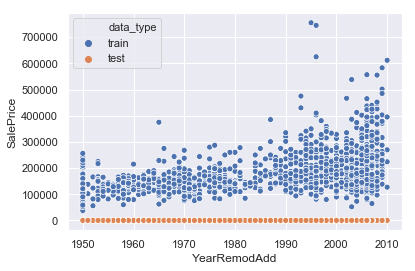

data_type  MasVnrArea
test       0.0           877
           176.0          10
           144.0           9
           120.0           8
           216.0           8
           200.0           7
           128.0           6
           198.0           6
           302.0           6
           504.0           6
           60.0            5
           140.0           5
           164.0           5
           196.0           5
           203.0           5
           210.0           5
           256.0           5
           260.0           5
           16.0            4
           20.0            4
           23.0            4
           40.0            4
           44.0            4
           50.0            4
           88.0            4
           112.0           4
           143.0           4
           150.0           4
           174.0           4
           178.0           4
           180.0           4
           186.0           4
           194.0           4
           232.0     

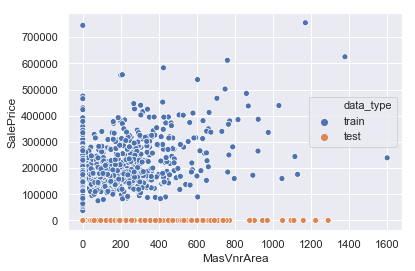

data_type  BsmtFinSF1
test       0.0           462
           24.0           15
           276.0           6
           602.0           6
           16.0            5
           288.0           5
           300.0           5
           758.0           5
           60.0            4
           252.0           4
           330.0           4
           368.0           4
           375.0           4
           384.0           4
           456.0           4
           468.0           4
           476.0           4
           500.0           4
           544.0           4
           600.0           4
           624.0           4
           700.0           4
           864.0           4
           915.0           4
           20.0            3
           36.0            3
           68.0            3
           80.0            3
           104.0           3
           110.0           3
           114.0           3
           119.0           3
           120.0           3
           130.0     

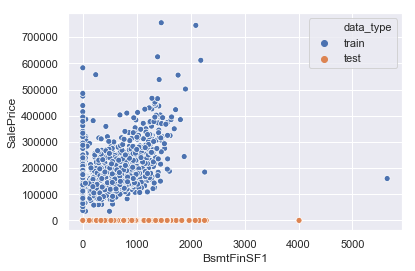

data_type  BsmtFinSF2
test       0.0           1278
           162.0            3
           294.0            3
           483.0            3
           42.0             2
           60.0             2
           72.0             2
           116.0            2
           144.0            2
           159.0            2
           168.0            2
           247.0            2
           252.0            2
           270.0            2
           288.0            2
           435.0            2
           590.0            2
           596.0            2
           6.0              1
           12.0             1
           38.0             1
           40.0             1
           46.0             1
           48.0             1
           52.0             1
           63.0             1
           66.0             1
           68.0             1
           76.0             1
           78.0             1
           80.0             1
           92.0             1
           95.0   

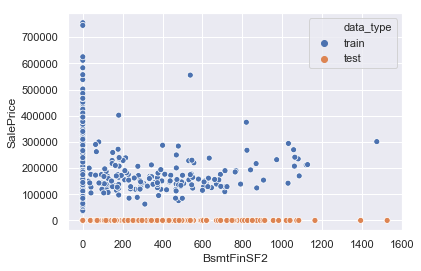

data_type  BsmtUnfSF
test       0.0          123
           384.0         11
           624.0          8
           100.0          7
           348.0          7
           480.0          7
           672.0          7
           738.0          7
           120.0          6
           216.0          6
           294.0          6
           784.0          6
           816.0          6
           30.0           5
           150.0          5
           186.0          5
           226.0          5
           228.0          5
           240.0          5
           306.0          5
           322.0          5
           396.0          5
           405.0          5
           456.0          5
           525.0          5
           546.0          5
           585.0          5
           600.0          5
           728.0          5
           768.0          5
           832.0          5
           160.0          4
           166.0          4
           190.0          4
           195.0          4

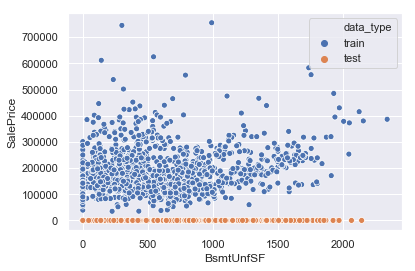

data_type  TotalBsmtSF
test       0.0            41
           864.0          39
           960.0          13
           384.0          12
           546.0          12
           672.0          12
           768.0          12
           1008.0         12
           912.0          11
           1040.0         11
           624.0          10
           816.0          10
           988.0          10
           600.0           9
           720.0           9
           728.0           8
           738.0           8
           756.0           8
           780.0           8
           936.0           8
           483.0           7
           784.0           7
           832.0           7
           1168.0          7
           840.0           6
           894.0           6
           1100.0          6
           572.0           5
           676.0           5
           796.0           5
           835.0           5
           836.0           5
           848.0           5
           855.0    

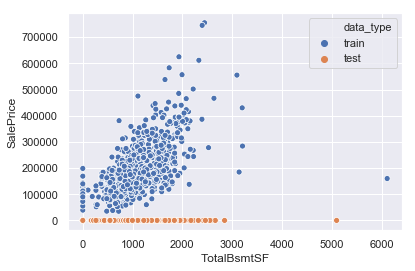

data_type  1stFlrSF
test       864         21
           546         12
           1040        12
           960         11
           936         10
           816          9
           768          8
           1008         8
           1072         7
           1152         7
           483          6
           672          6
           728          6
           832          6
           840          6
           848          6
           925          6
           988          6
           1055         6
           1337         6
           1358         6
           600          5
           624          5
           738          5
           744          5
           754          5
           825          5
           845          5
           855          5
           884          5
           894          5
           896          5
           912          5
           914          5
           928          5
           984          5
           1114         5
           1200   

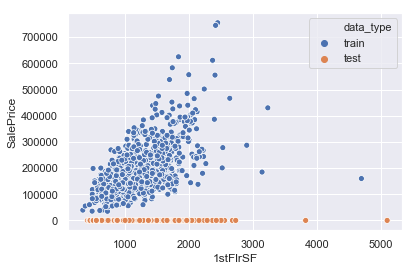

data_type  2ndFlrSF
test       0           839
           546          15
           504           8
           728           8
           886           7
           600           6
           720           6
           462           5
           601           5
           624           5
           630           5
           672           5
           896           5
           567           4
           636           4
           676           4
           744           4
           754           4
           756           4
           780           4
           378           3
           412           3
           424           3
           516           3
           536           3
           550           3
           588           3
           595           3
           644           3
           656           3
           662           3
           678           3
           702           3
           750           3
           768           3
           784           3
        

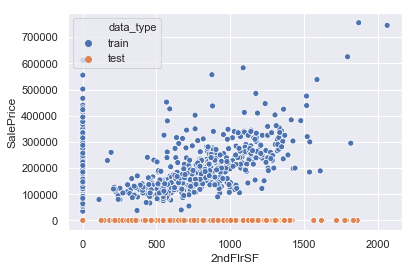

data_type  LowQualFinSF
test       0               1445
           80                 1
           108                1
           114                1
           140                1
           205                1
           259                1
           312                1
           362                1
           431                1
           436                1
           450                1
           512                1
           697                1
           1064               1
train      0               1434
           80                 3
           360                2
           53                 1
           120                1
           144                1
           156                1
           205                1
           232                1
           234                1
           371                1
           384                1
           390                1
           392                1
           397                1
           420  

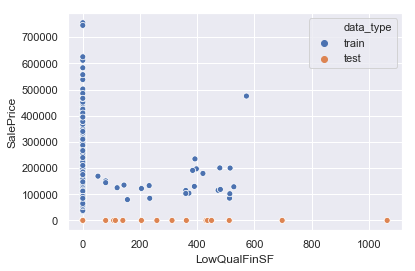

data_type  GrLivArea
test       864          19
           1092         18
           1040         11
           1456         10
           936           9
           1200          9
           960           7
           816           6
           988           6
           1152          6
           1337          6
           1358          6
           1374          6
           1560          6
           1728          6
           912           5
           925           5
           984           5
           987           5
           1008          5
           1055          5
           1072          5
           1324          5
           1342          5
           1430          5
           1436          5
           1440          5
           1488          5
           1680          5
           894           4
           914           4
           1020          4
           1032          4
           1073          4
           1114          4
           1142          4
       

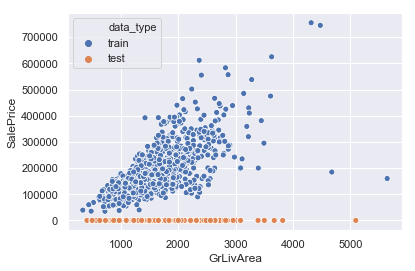

data_type  BsmtFullBath
test       0.0             849
           1.0             584
           2.0              23
           3.0               1
train      0.0             856
           1.0             588
           2.0              15
           3.0               1
Name: BsmtFullBath, dtype: int64


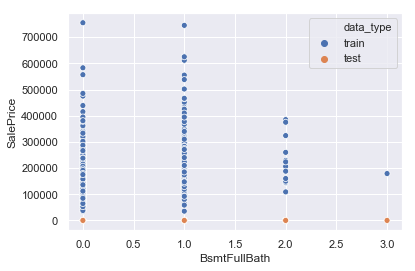

data_type  BsmtHalfBath
test       0.0             1364
           1.0               91
           2.0                2
train      0.0             1378
           1.0               80
           2.0                2
Name: BsmtHalfBath, dtype: int64


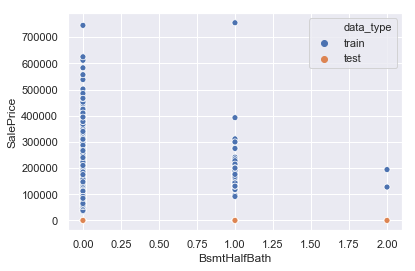

data_type  FullBath
test       2           762
           1           659
           3            31
           4             4
           0             3
train      2           768
           1           650
           3            33
           0             9
Name: FullBath, dtype: int64


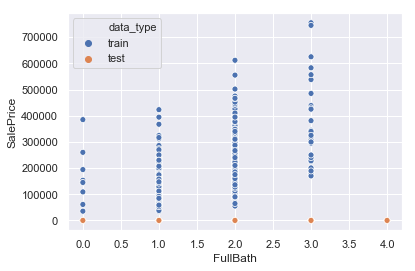

data_type  HalfBath
test       0           921
           1           525
           2            13
train      0           913
           1           535
           2            12
Name: HalfBath, dtype: int64


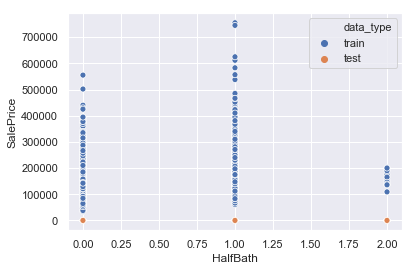

data_type  BedroomAbvGr
test       3               792
           2               384
           4               187
           1                53
           5                27
           6                14
           0                 2
train      3               804
           2               358
           4               213
           1                50
           5                21
           6                 7
           0                 6
           8                 1
Name: BedroomAbvGr, dtype: int64


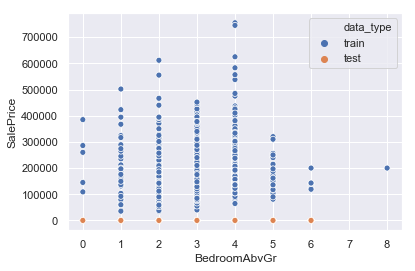

data_type  KitchenAbvGr
test       1               1393
           2                 64
           0                  2
train      1               1392
           2                 65
           3                  2
           0                  1
Name: KitchenAbvGr, dtype: int64


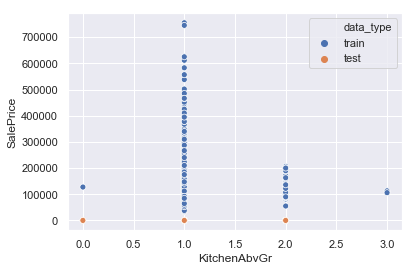

data_type  TotRmsAbvGrd
test       6               442
           7               320
           5               308
           8               160
           4                99
           9                68
           10               33
           11               14
           3                 8
           12                5
           13                1
           15                1
train      6               402
           7               329
           5               275
           8               187
           4                97
           9                75
           10               47
           11               18
           3                17
           12               11
           2                 1
           14                1
Name: TotRmsAbvGrd, dtype: int64


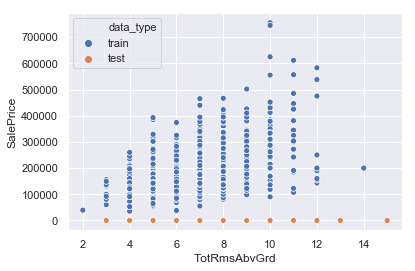

data_type  Fireplaces
test       0             730
           1             618
           2             104
           3               6
           4               1
train      0             690
           1             650
           2             115
           3               5
Name: Fireplaces, dtype: int64


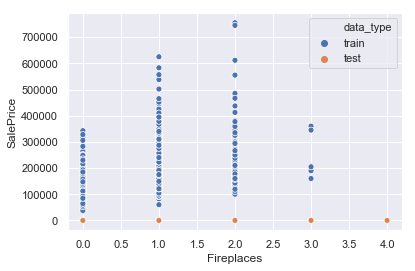

data_type  GarageYrBlt
test       2005.0         77
           2007.0         66
           2006.0         56
           2004.0         46
           2003.0         42
           2008.0         32
           1977.0         31
           2000.0         28
           1950.0         27
           1993.0         27
           1998.0         27
           2002.0         27
           1956.0         25
           1997.0         25
           1999.0         24
           1968.0         22
           1978.0         22
           1958.0         21
           1967.0         21
           1976.0         21
           1994.0         21
           2001.0         21
           1979.0         20
           1996.0         20
           1920.0         19
           1930.0         19
           1959.0         19
           1975.0         19
           1954.0         18
           1960.0         18
           1961.0         18
           1963.0         18
           1966.0         18
           1964.0   

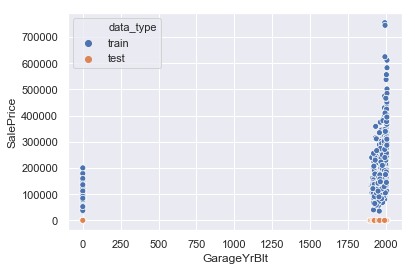

data_type  GarageCars
test       2.0           770
           1.0           407
           3.0           193
           0.0            76
           4.0            11
           5.0             1
train      2.0           824
           1.0           369
           3.0           181
           0.0            81
           4.0             5
Name: GarageCars, dtype: int64


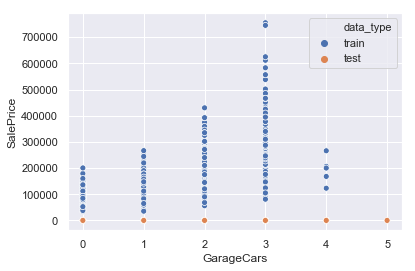

data_type  GarageArea
test       0.0           76
           576.0         50
           440.0         47
           484.0         34
           400.0         33
           528.0         32
           240.0         31
           480.0         30
           308.0         28
           264.0         27
           288.0         23
           336.0         17
           280.0         14
           506.0         14
           462.0         13
           495.0         13
           384.0         12
           216.0         11
           286.0         11
           525.0         11
           312.0         10
           420.0         10
           624.0         10
           504.0          9
           550.0          9
           390.0          8
           478.0          8
           672.0          8
           180.0          7
           200.0          7
           297.0          7
           441.0          7
           460.0          7
           470.0          7
           473.0          

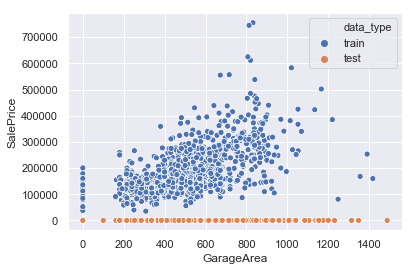

data_type  WoodDeckSF
test       0             762
           100            38
           192            32
           144            28
           168            28
           120            22
           140            14
           200            11
           240            10
           160             9
           143             8
           108             7
           128             7
           280             7
           136             6
           150             6
           156             6
           182             6
           204             6
           210             6
           252             6
           256             6
           80              5
           112             5
           135             5
           154             5
           176             5
           184             5
           188             5
           208             5
           224             5
           36              4
           48              4
           64        

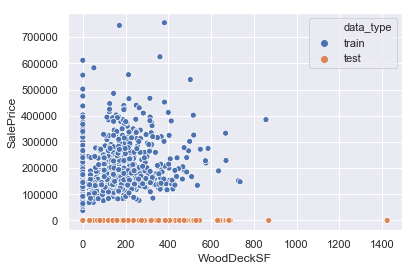

data_type  OpenPorchSF
test       0              642
           48              29
           32              27
           40              25
           36              23
           28              21
           24              20
           50              16
           30              15
           64              15
           60              14
           84              13
           20              12
           35              12
           68              12
           90              12
           38              11
           39              11
           26              10
           72              10
           34               9
           45               9
           55               9
           56               9
           96               9
           120              9
           21               8
           52               8
           53               8
           102              8
           108              8
           16               7
           42    

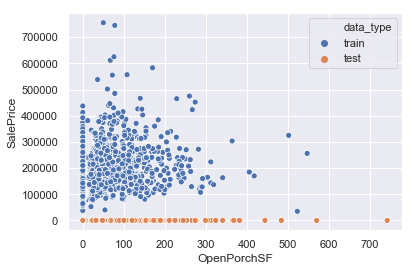

data_type  EnclosedPorch
test       0                1208
           96                  7
           112                 7
           168                 7
           84                  6
           144                 6
           40                  5
           60                  5
           160                 5
           180                 5
           192                 5
           56                  4
           70                  4
           100                 4
           116                 4
           120                 4
           128                 4
           140                 4
           148                 4
           150                 4
           35                  3
           36                  3
           42                  3
           55                  3
           64                  3
           80                  3
           90                  3
           105                 3
           240                 3
           280    

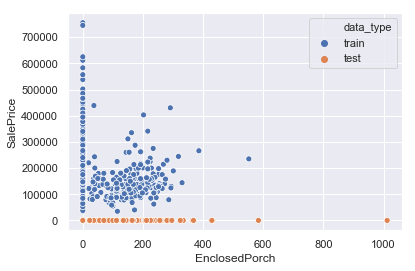

data_type  3SsnPorch
test       0            1446
           153             2
           86              1
           120             1
           150             1
           174             1
           176             1
           219             1
           224             1
           225             1
           255             1
           323             1
           360             1
train      0            1436
           168             3
           144             2
           180             2
           216             2
           23              1
           96              1
           130             1
           140             1
           153             1
           162             1
           182             1
           196             1
           238             1
           245             1
           290             1
           304             1
           320             1
           407             1
           508             1
Name: 3SsnPorch, dtype

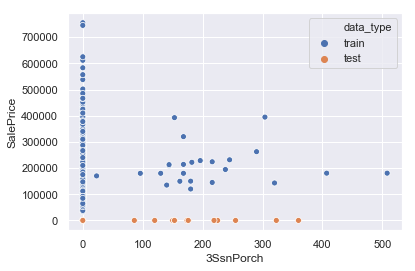

data_type  ScreenPorch
test       0              1319
           144              10
           168               7
           216               6
           192               5
           200               5
           120               4
           100               3
           112               3
           115               3
           153               3
           155               3
           156               3
           160               3
           180               3
           195               3
           225               3
           256               3
           92                2
           108               2
           110               2
           138               2
           161               2
           175               2
           182               2
           196               2
           210               2
           227               2
           240               2
           255               2
           288               2
           64   

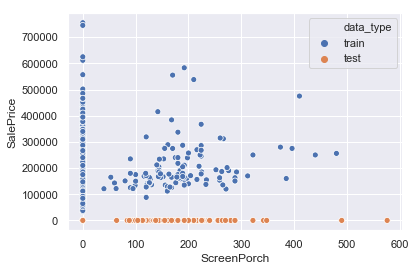

data_type  PoolArea
test       0           1453
           144            1
           228            1
           368            1
           444            1
           561            1
           800            1
train      0           1453
           480            1
           512            1
           519            1
           555            1
           576            1
           648            1
           738            1
Name: PoolArea, dtype: int64


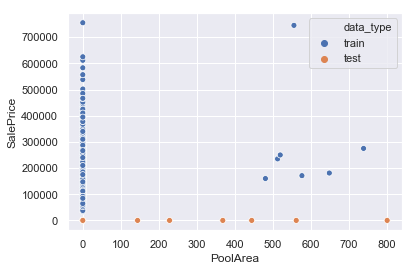

data_type  MiscVal
test       0          1408
           400           7
           450           5
           500           5
           600           4
           650           3
           1500          3
           2000          3
           700           2
           3000          2
           4500          2
           80            1
           300           1
           420           1
           455           1
           460           1
           490           1
           750           1
           900           1
           1000          1
           1200          1
           1512          1
           2500          1
           6500          1
           12500         1
           17000         1
train      0          1408
           400          11
           500           8
           700           5
           450           4
           600           4
           2000          4
           480           2
           1200          2
           54            1
         

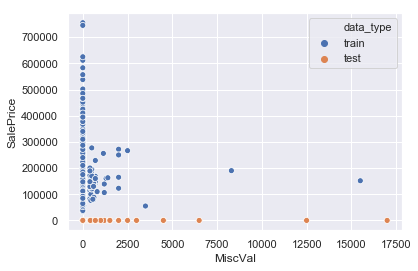

data_type  MoSold
test       6         250
           7         212
           5         190
           4         138
           3         126
           8         111
           9          95
           10         84
           2          81
           1          64
           11         63
           12         45
train      6         253
           7         234
           5         204
           4         141
           8         122
           3         106
           10         89
           11         79
           9          63
           12         59
           1          58
           2          52
Name: MoSold, dtype: int64


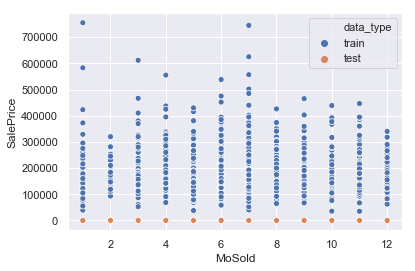

data_type  YrSold
test       2007      363
           2008      318
           2009      309
           2006      305
           2010      164
train      2009      338
           2007      329
           2006      314
           2008      304
           2010      175
Name: YrSold, dtype: int64


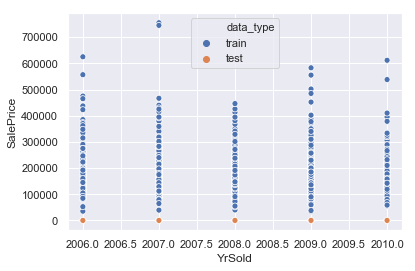

data_type  SalePrice
test       0            1459
train      140000         20
           135000         17
           145000         14
           155000         14
           110000         13
           190000         13
           115000         12
           160000         12
           130000         11
           139000         11
           125000         10
           143000         10
           144000         10
           180000         10
           185000         10
           100000          9
           127000          9
           147000          9
           175000          9
           129000          8
           141000          8
           165000          8
           170000          8
           176000          8
           200000          8
           215000          8
           230000          8
           250000          8
           112000          7
           119000          7
           120000          7
           128000          7
           148000     

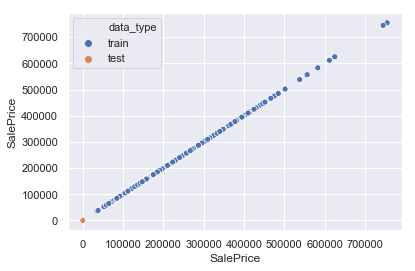

In [103]:
for i in num_cols: 
    print(all_df.groupby("data_type")[i].value_counts())
    sns.scatterplot(fin_df[i], fin_df.SalePrice, hue=fin_df.data_type)    
    plt.show()